In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')
#import os
#os.getcwd()
#import sys
#sys.path.append('/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy import stats
from scipy.signal import convolve2d
from copy import copy

from math import floor, ceil

import numpy as np
import tensorflow as tf
import logging

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plot_func as pf

import pickle

import dev_ori_sel_RF 

import plot_func as pf

from dev_ori_sel_RF.tools import gen_gaussian_random_field as ggrf
import dev_ori_sel_RF
from dev_ori_sel_RF import data_dir,integrator_tf,dynamics,network,run_onelayer,probe_RFs,plasticity_dynamics,run_full_plastic
from dev_ori_sel_RF.tools import misc,update_params_dict,analysis_tools

Default GPU Device: /device:GPU:0Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB


Default GPU Device: /device:GPU:0


In [220]:
config_name = 'ffrec_test'
Version = 23
with np.load('./../dev_ori_sel_RF/data/ffrec/'+config_name+'/v'+str(Version)+'/y_v'+str(Version)+'.npz') as data:
    print(list(data.keys()))
    Wlgn_to_4 = data['W']
    W4_to_4 = data['Wrec']
    l4 = data['l4']


['W', 'Wrec', 'l4']


Correlations Selectivity/Activity

/var/folders/r3/53wpv7m50yn1jsyfx9_mymtr0000gn/T/ipykernel_46657/2599135934.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=300)


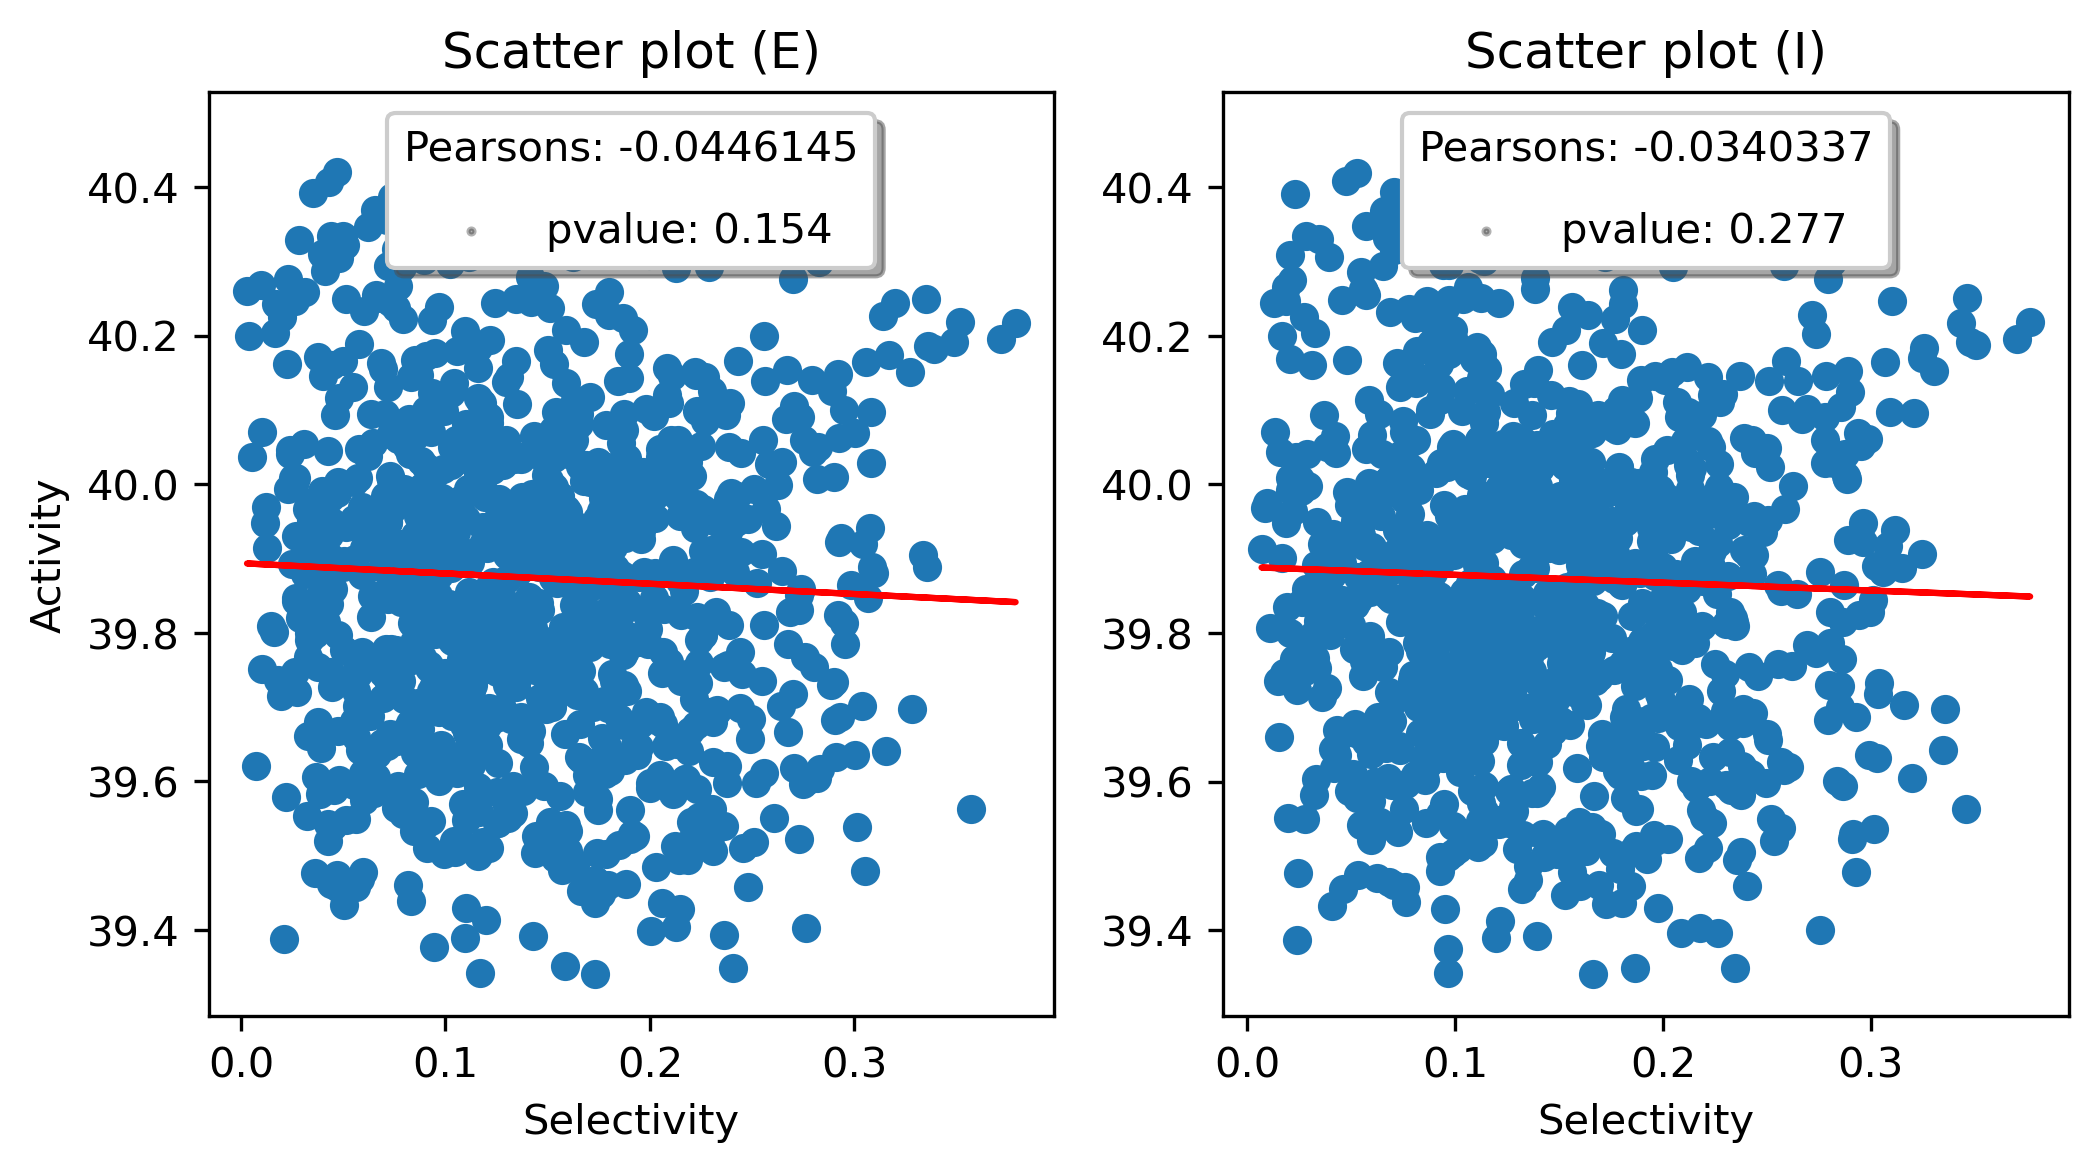

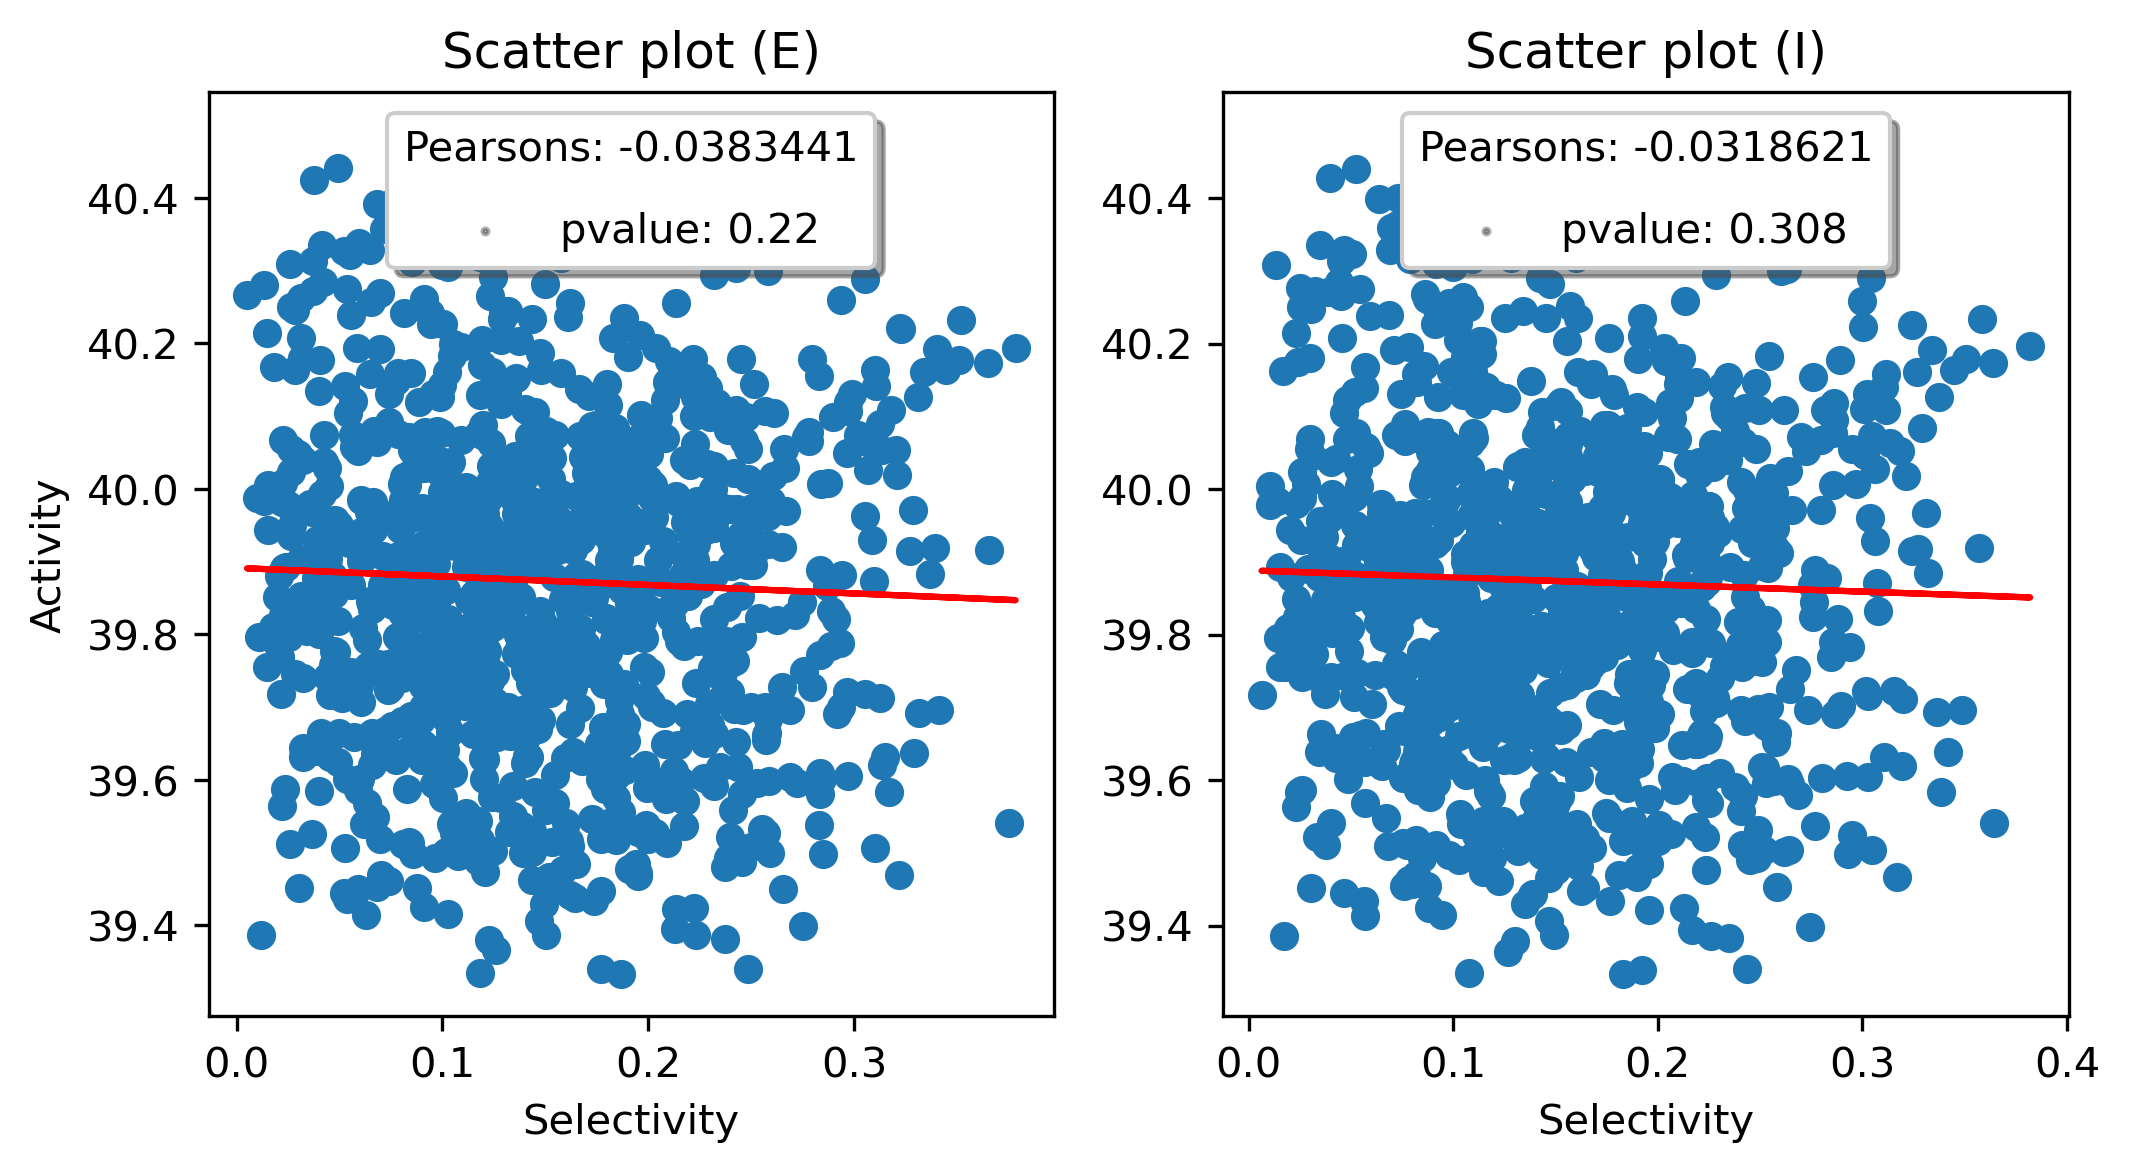

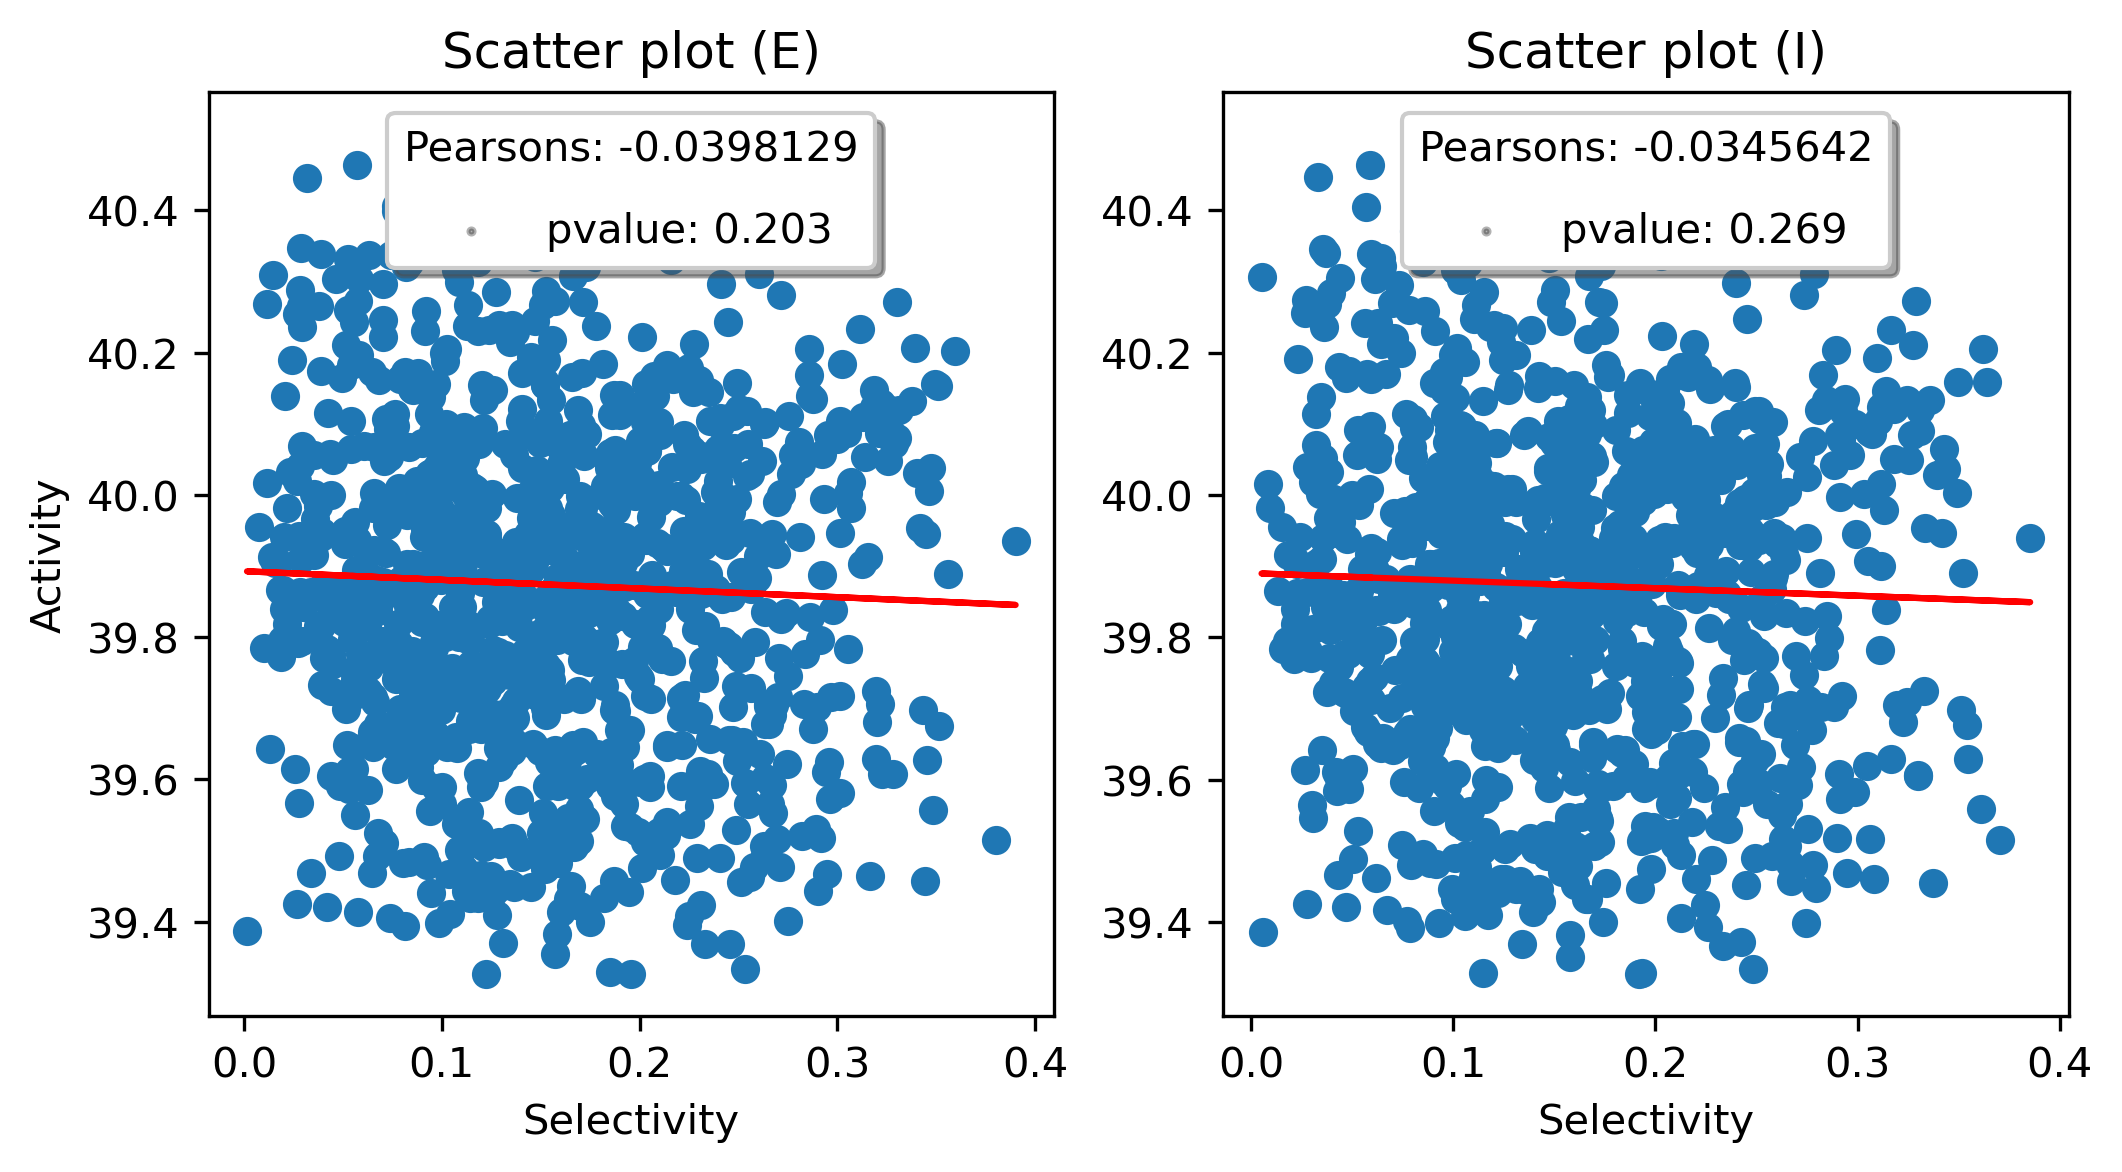

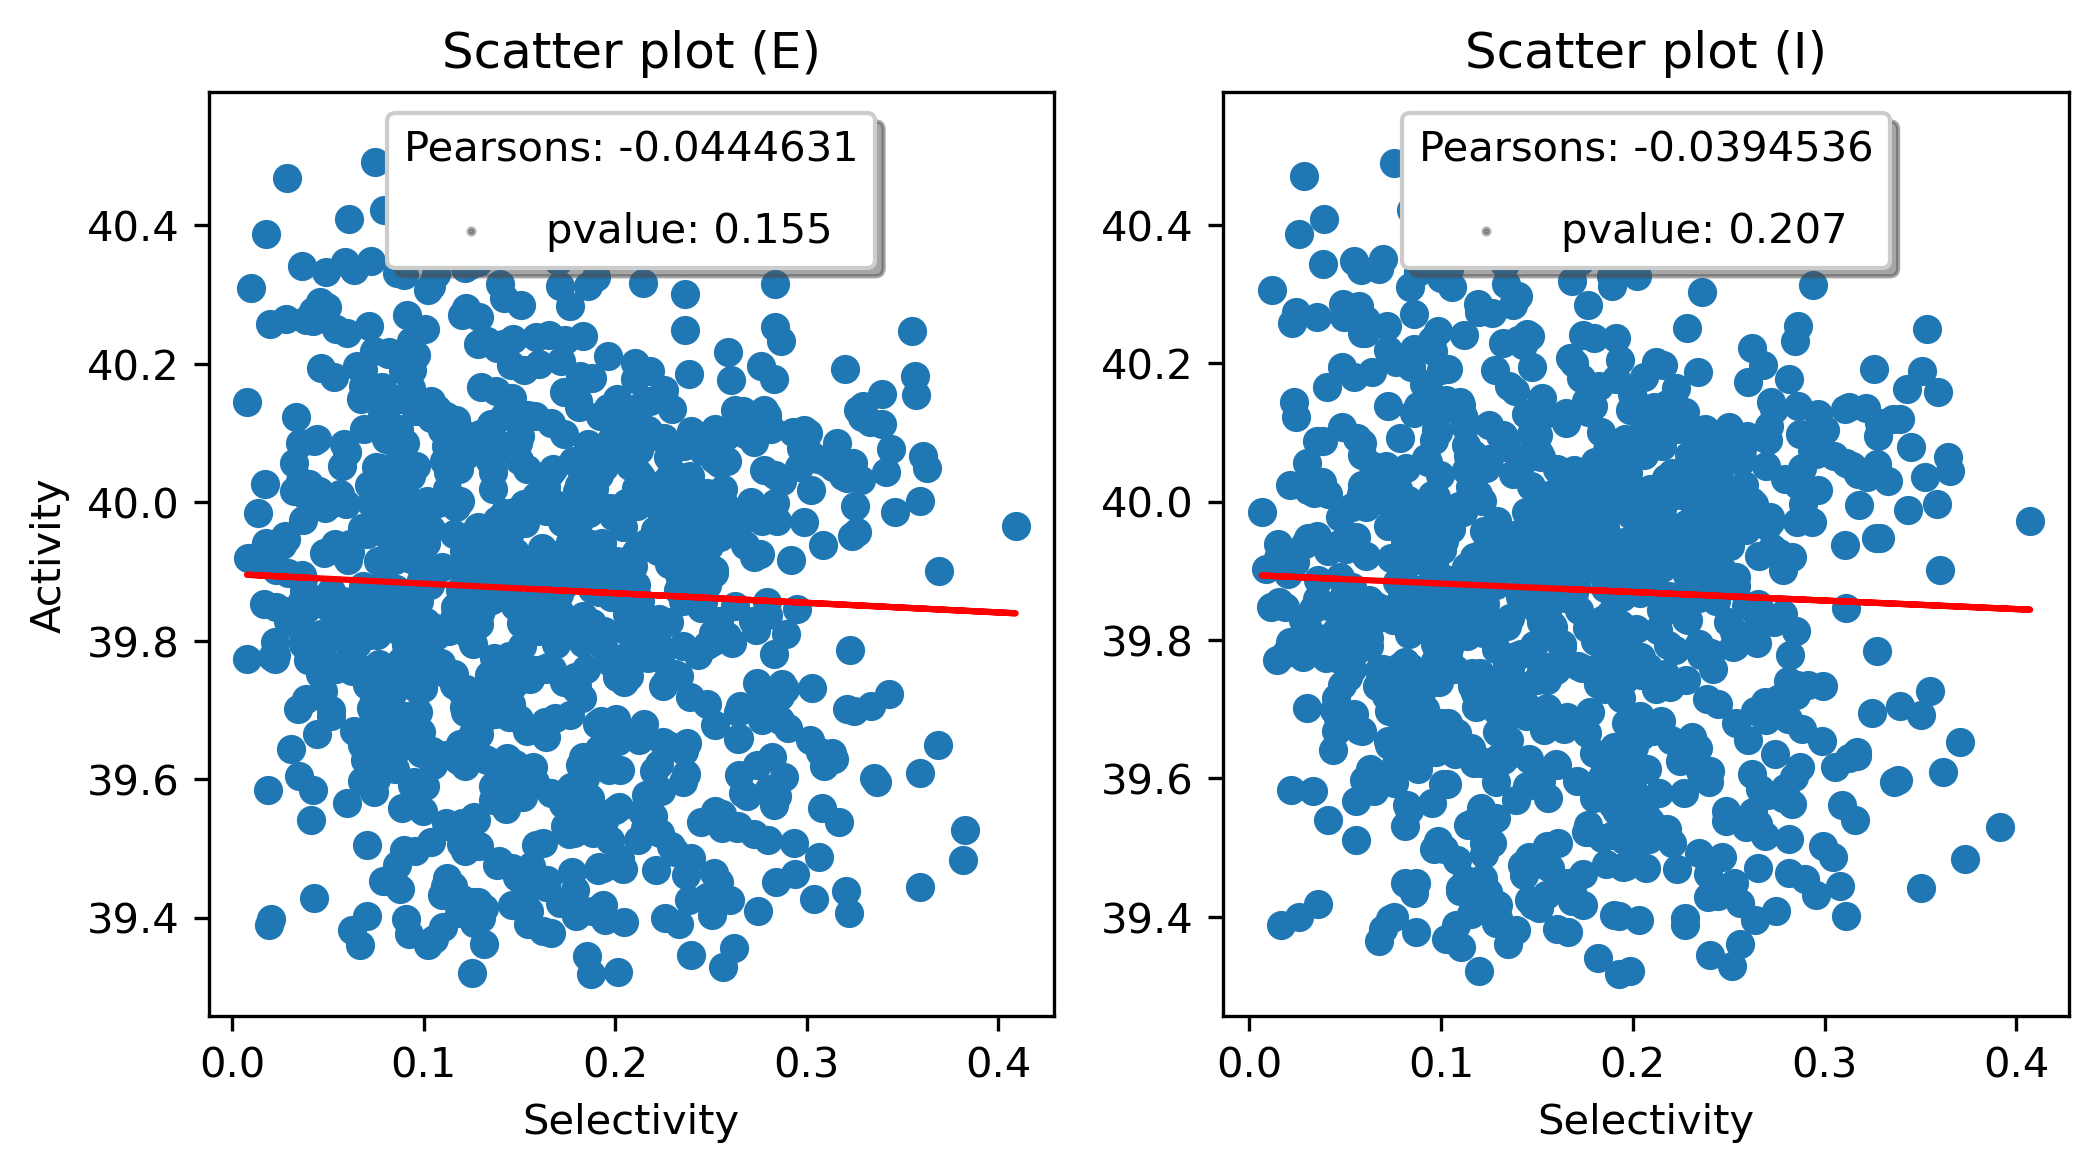

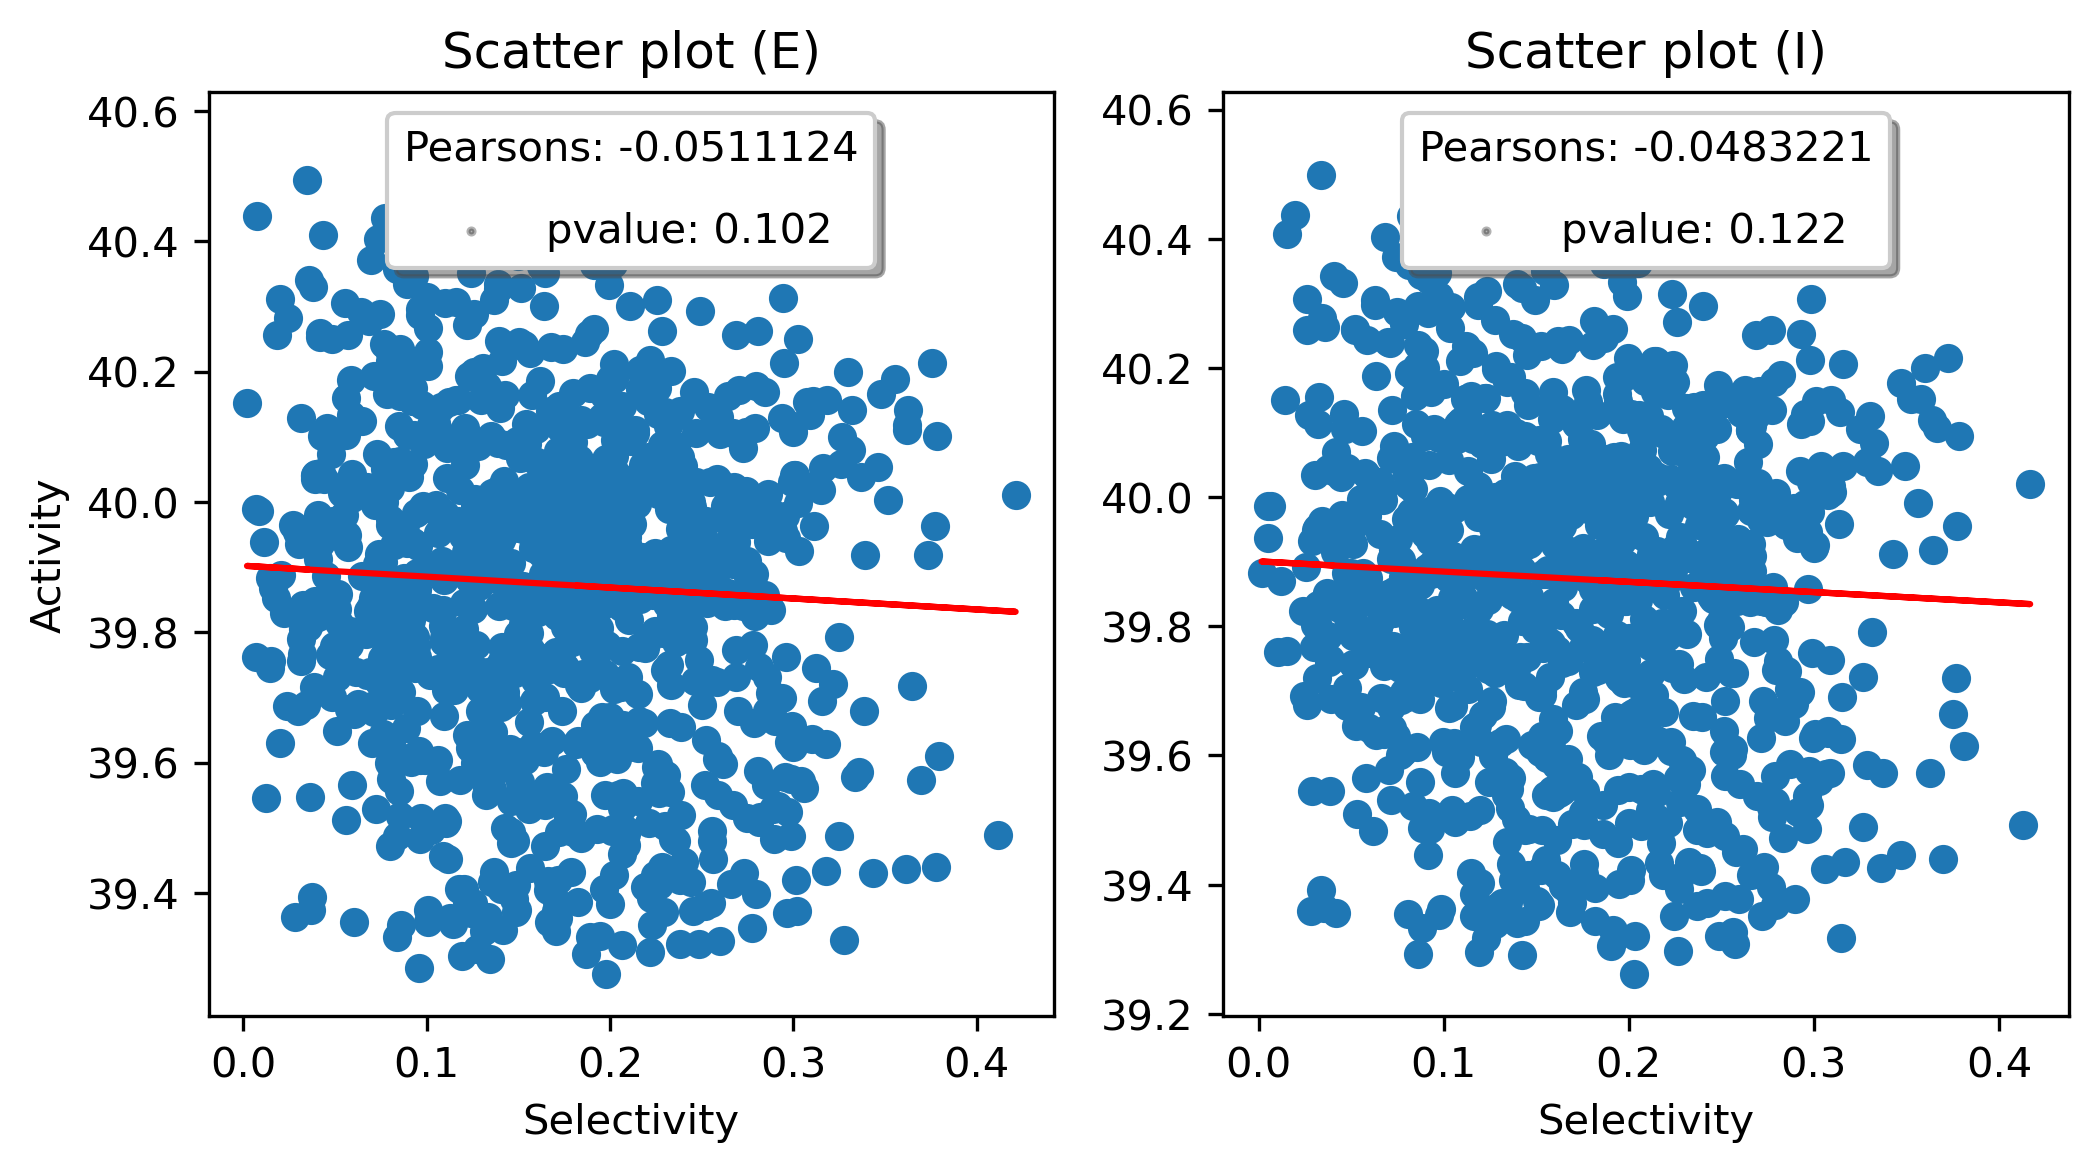

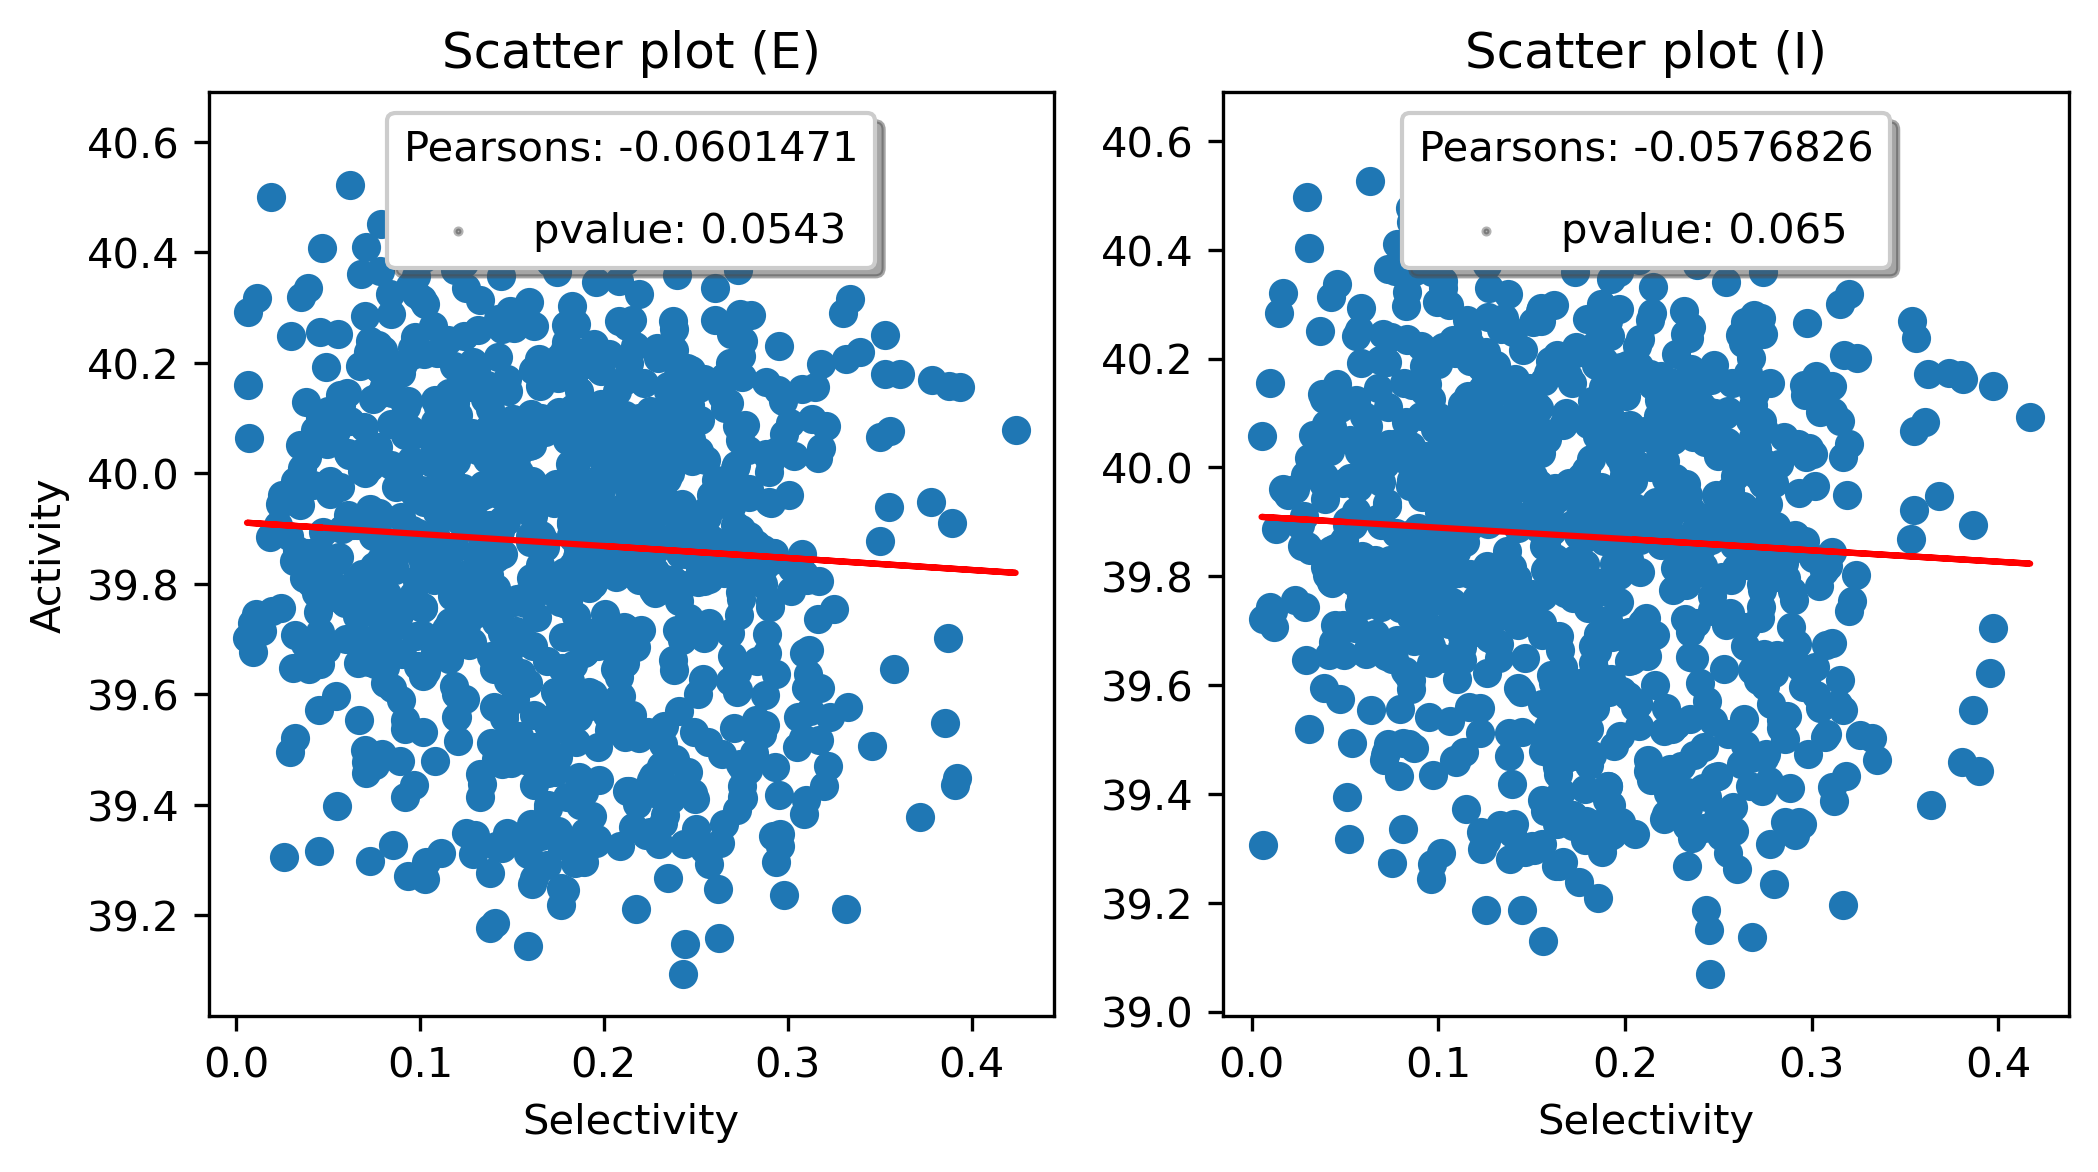

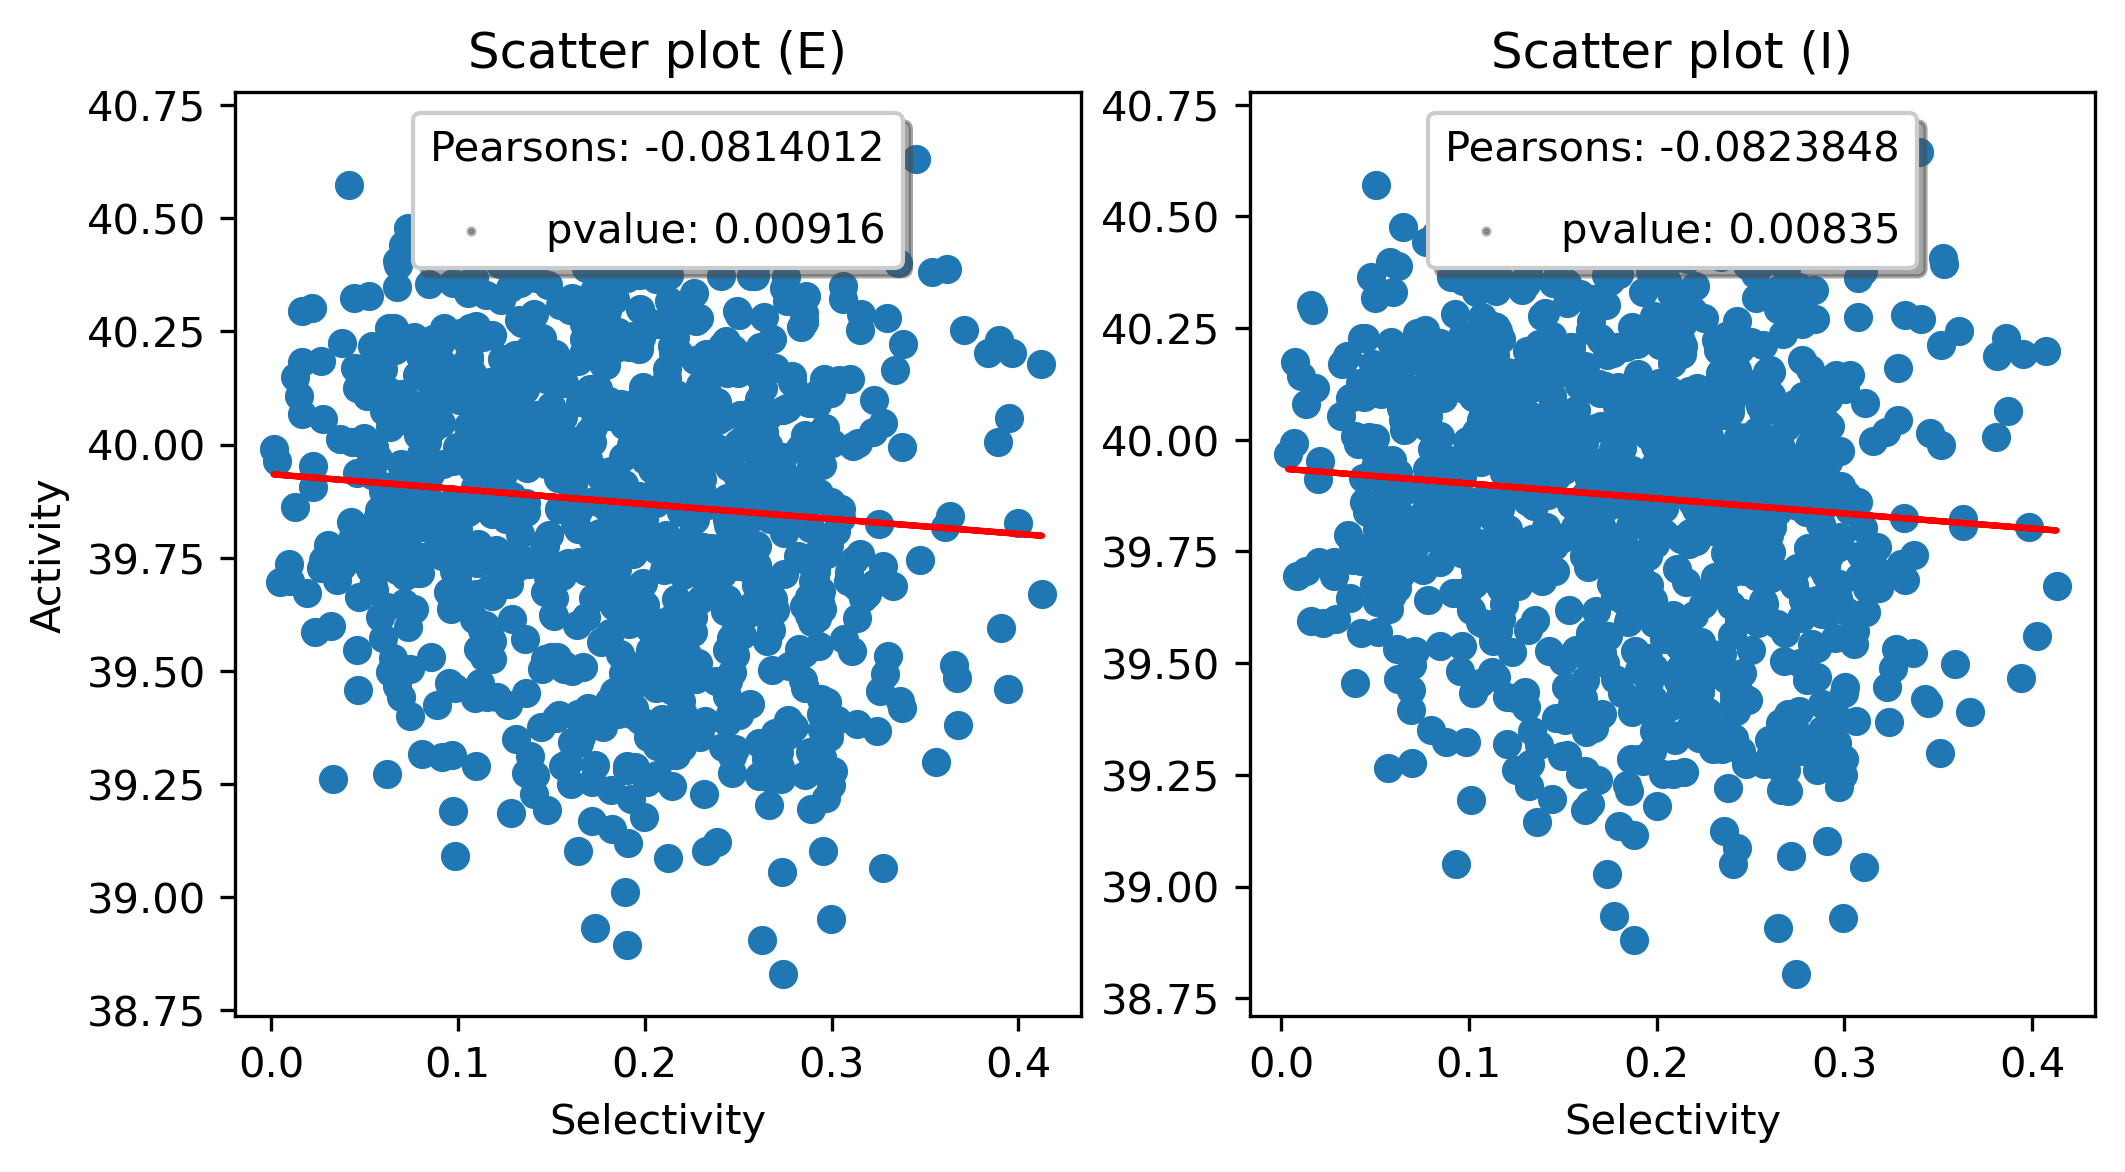

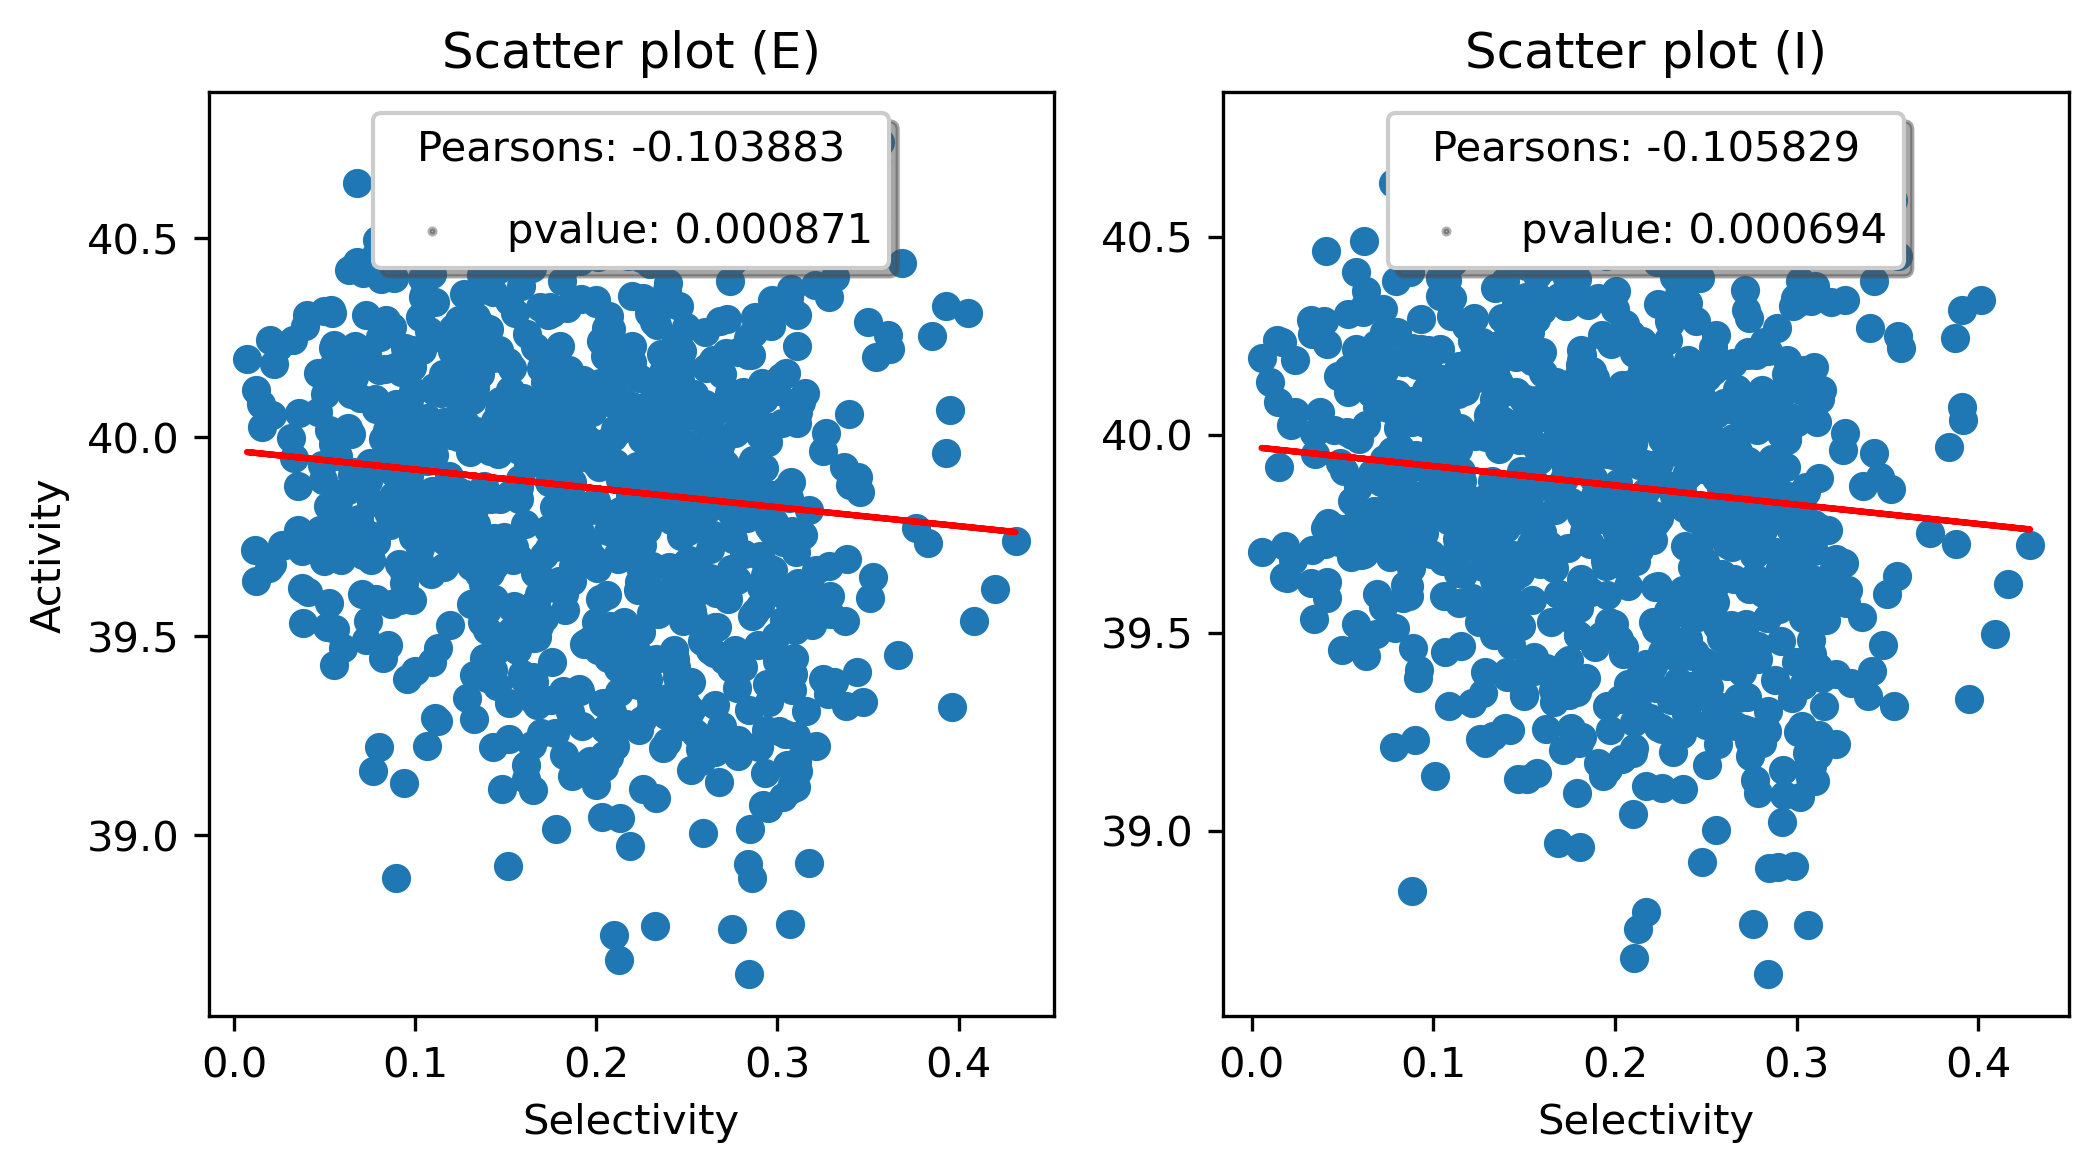

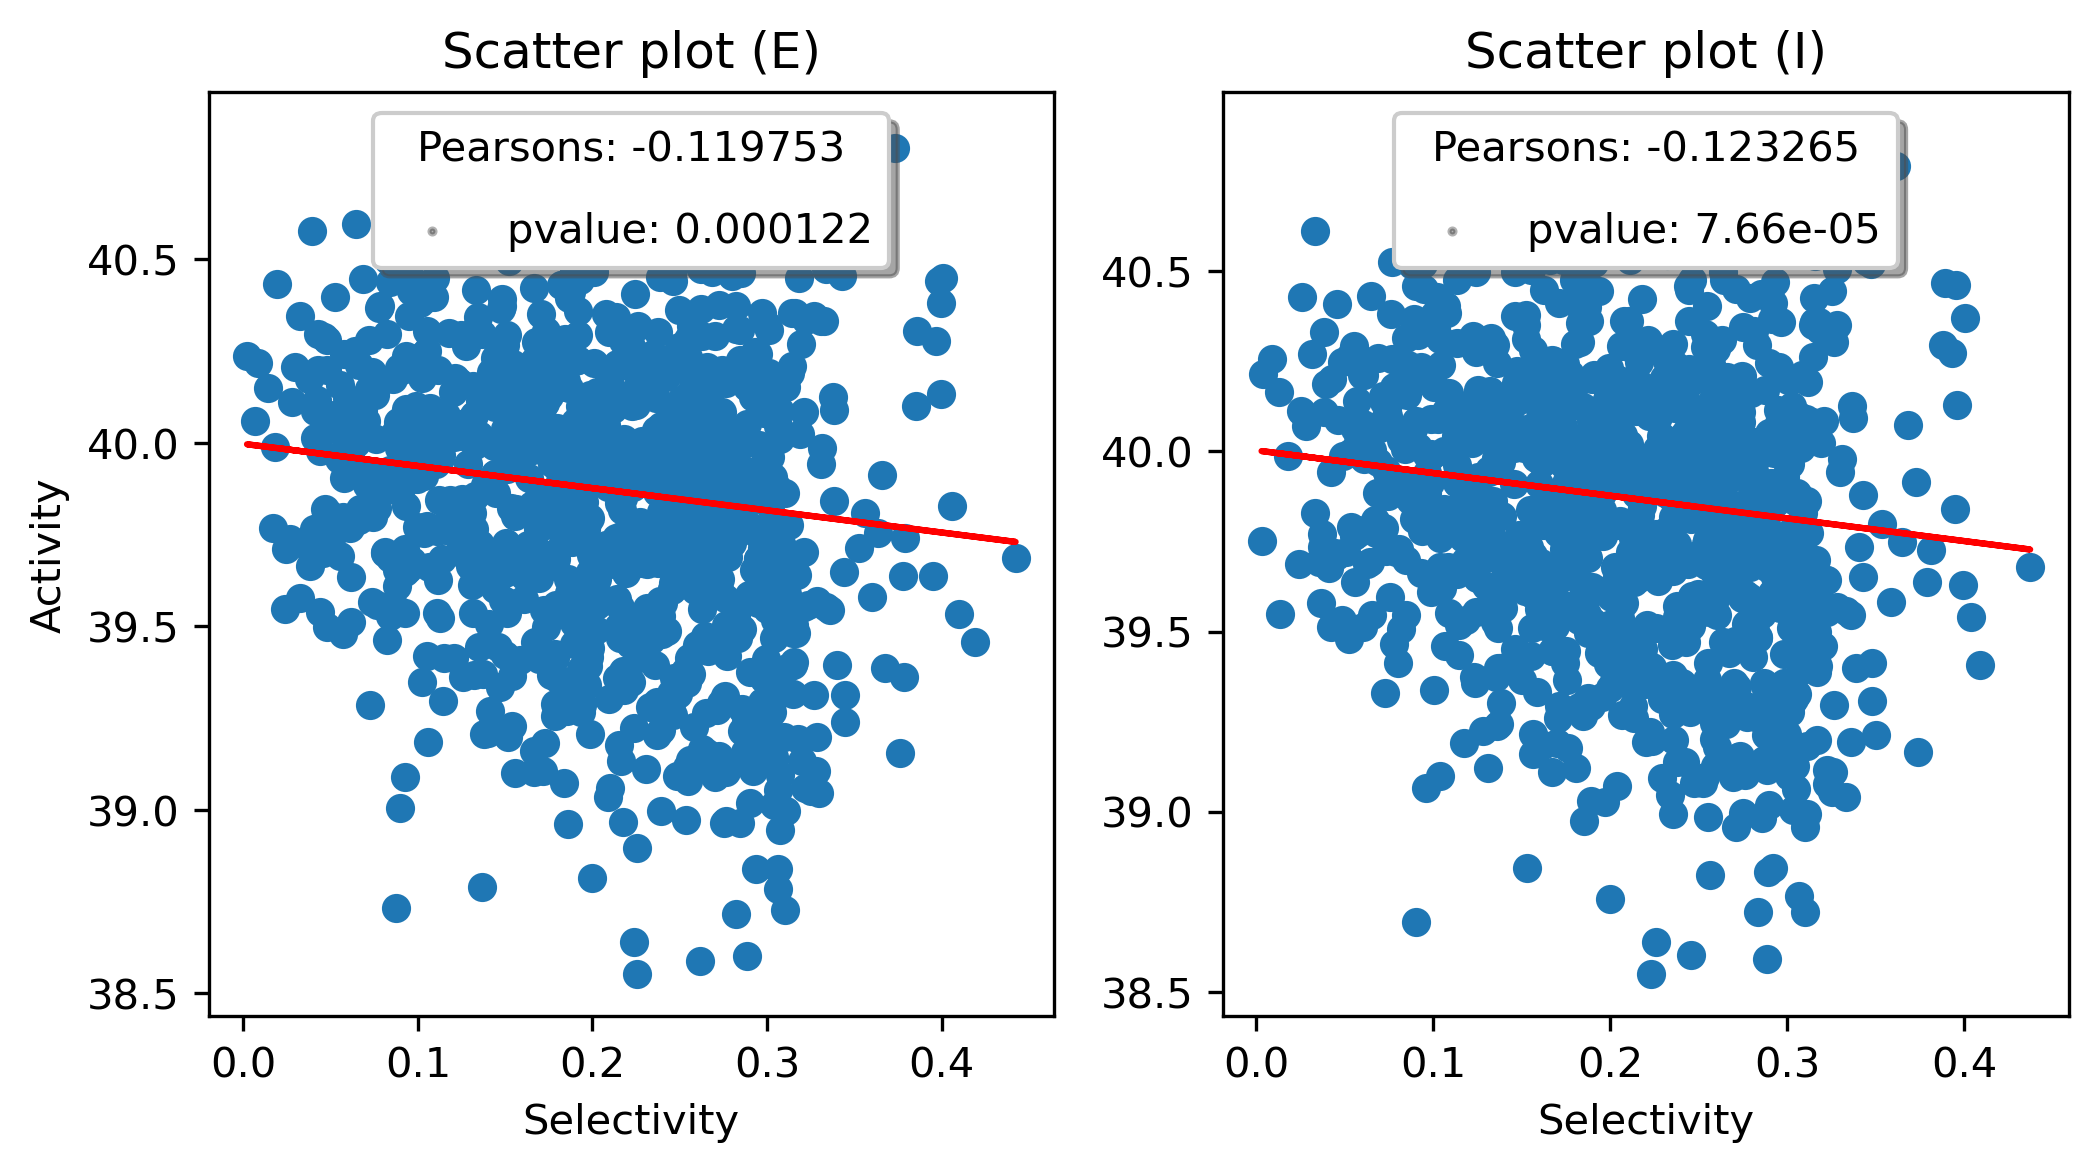

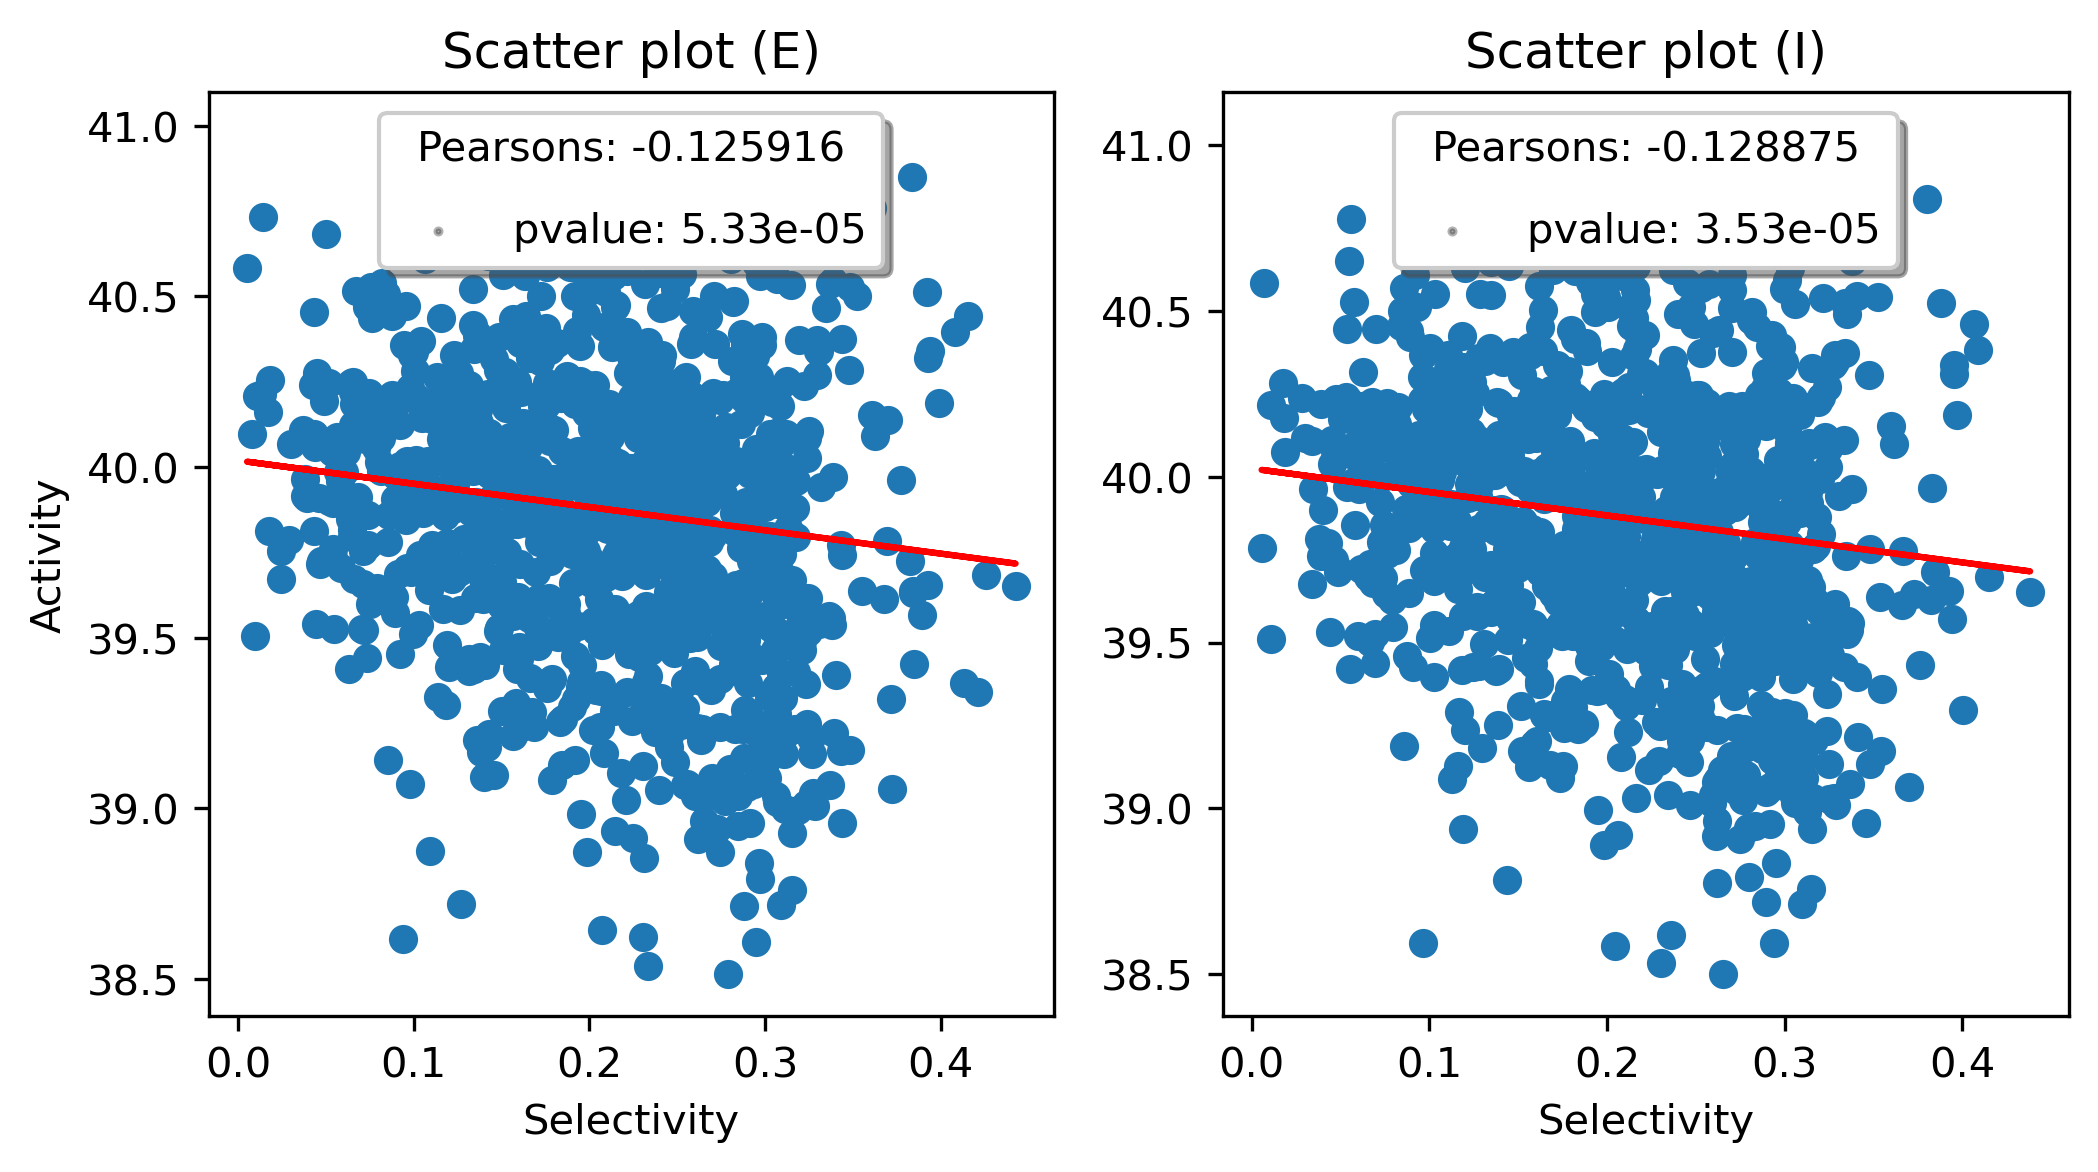

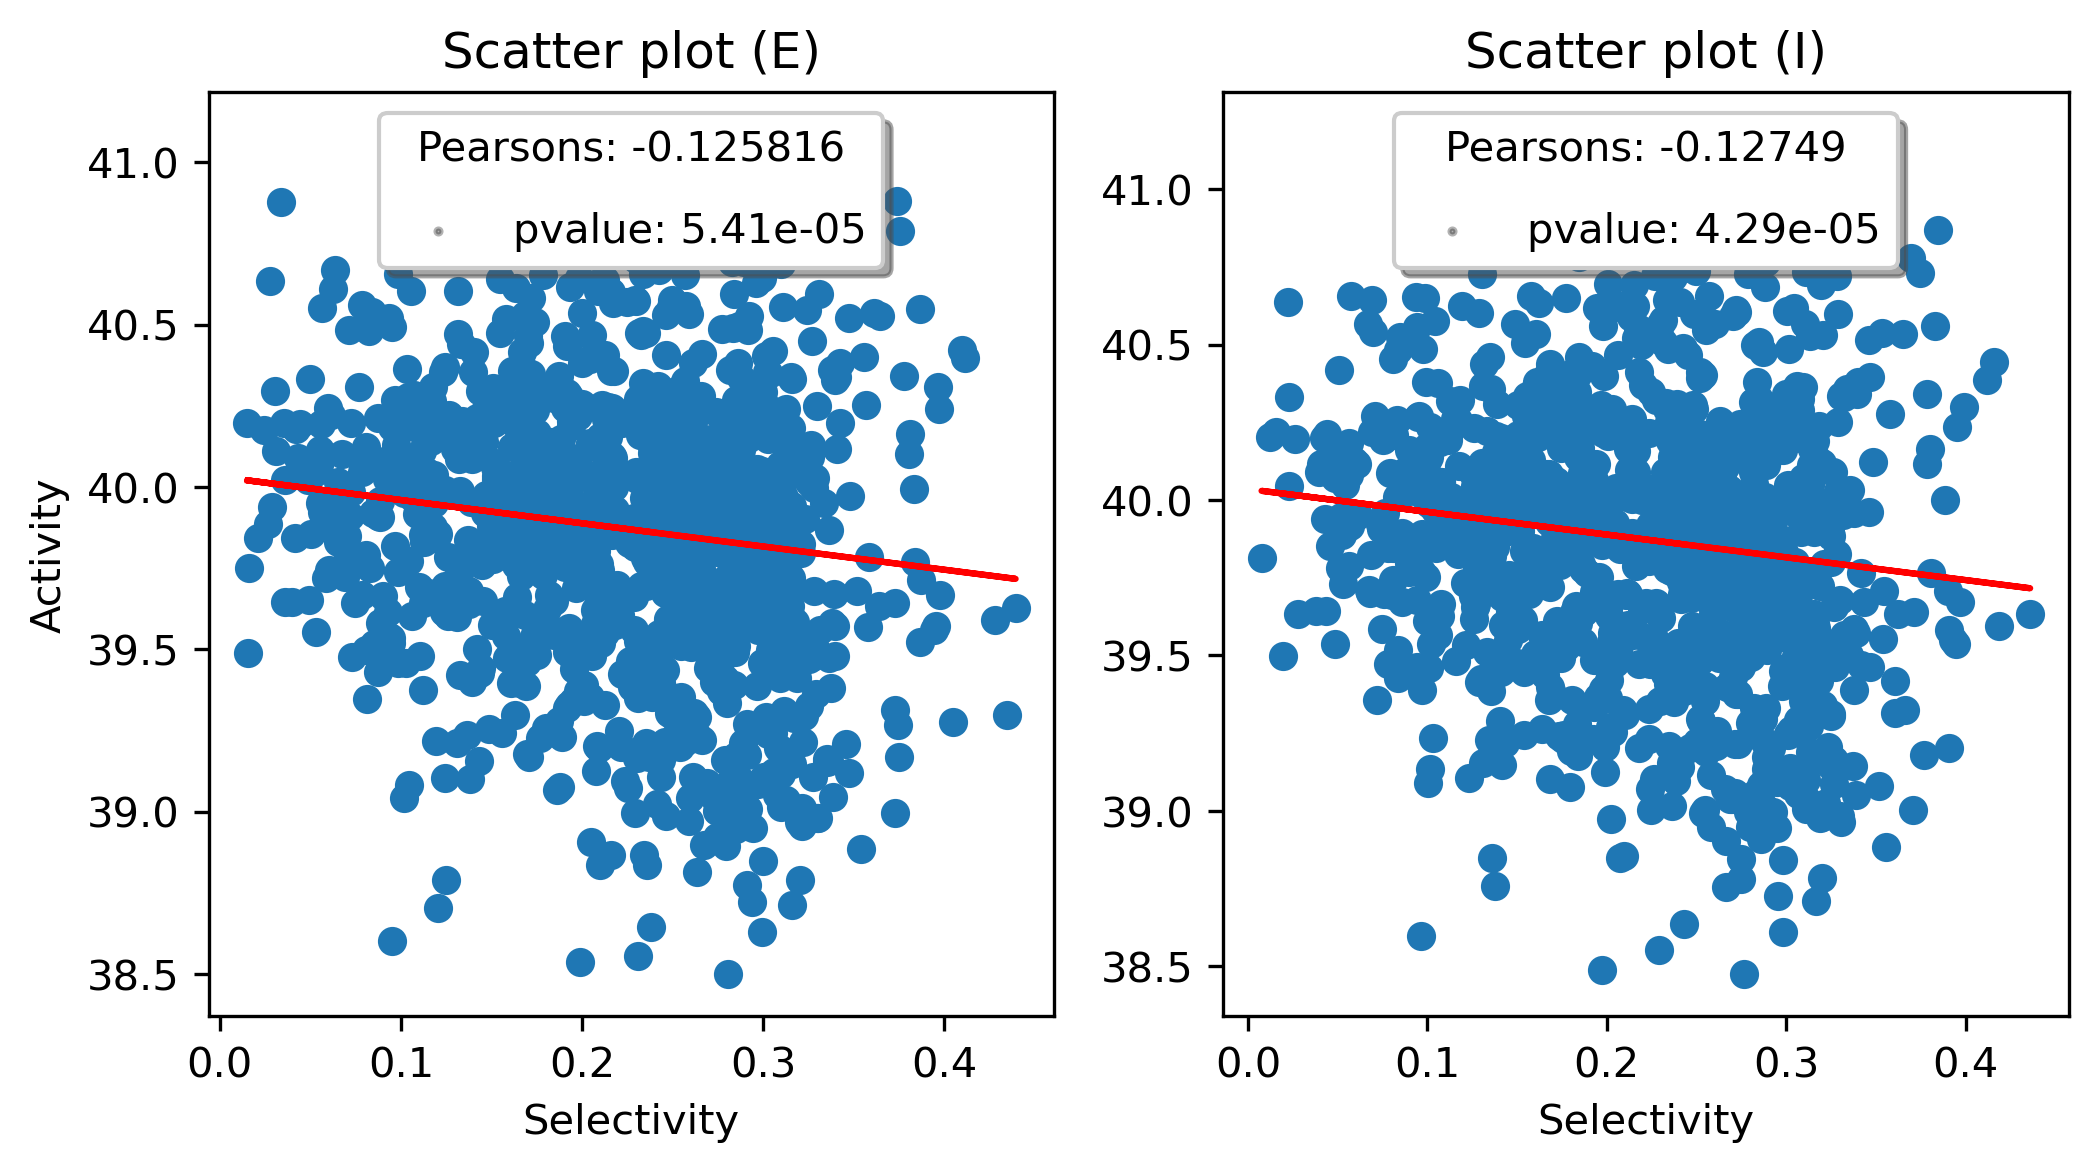

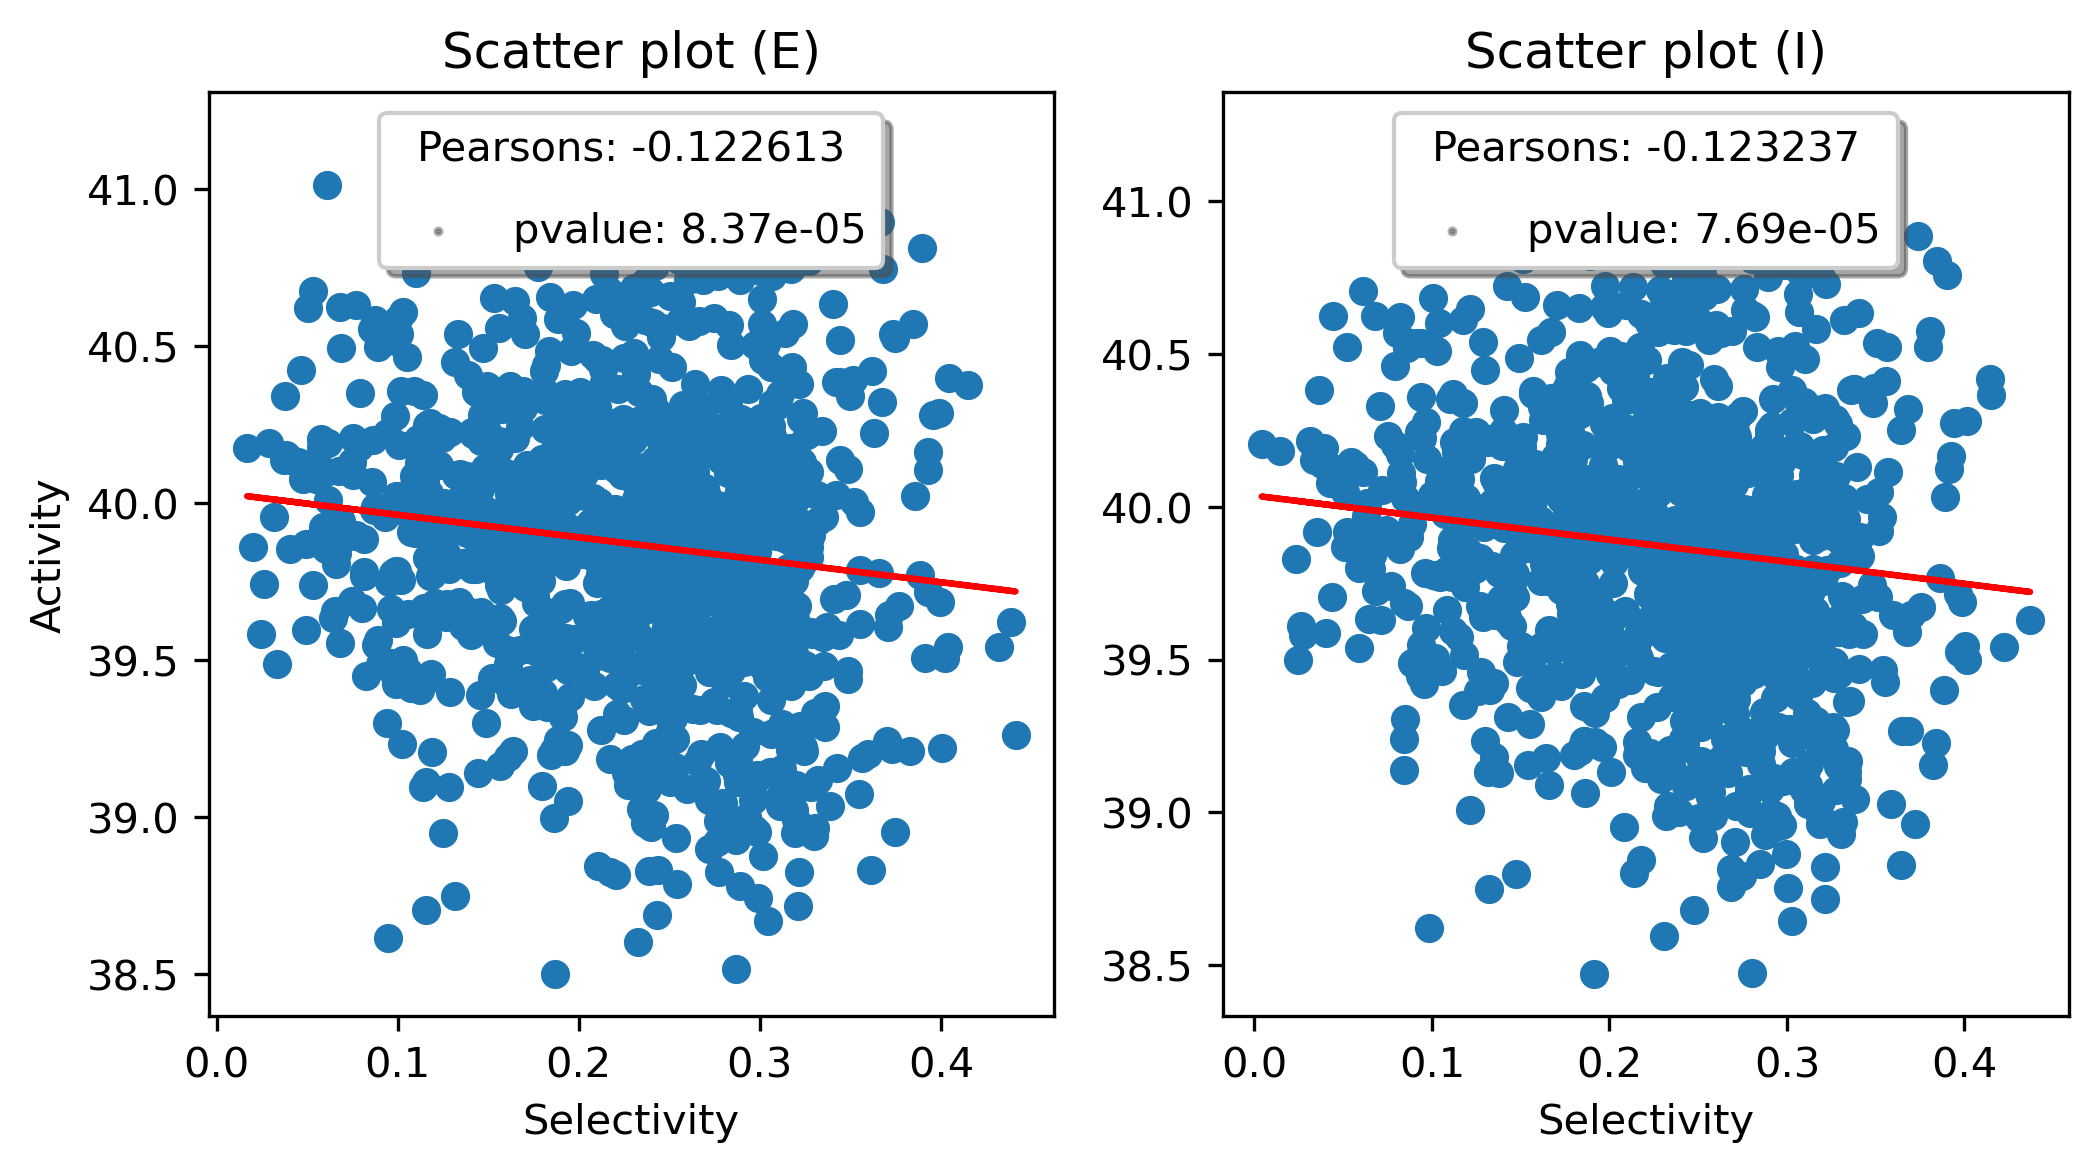

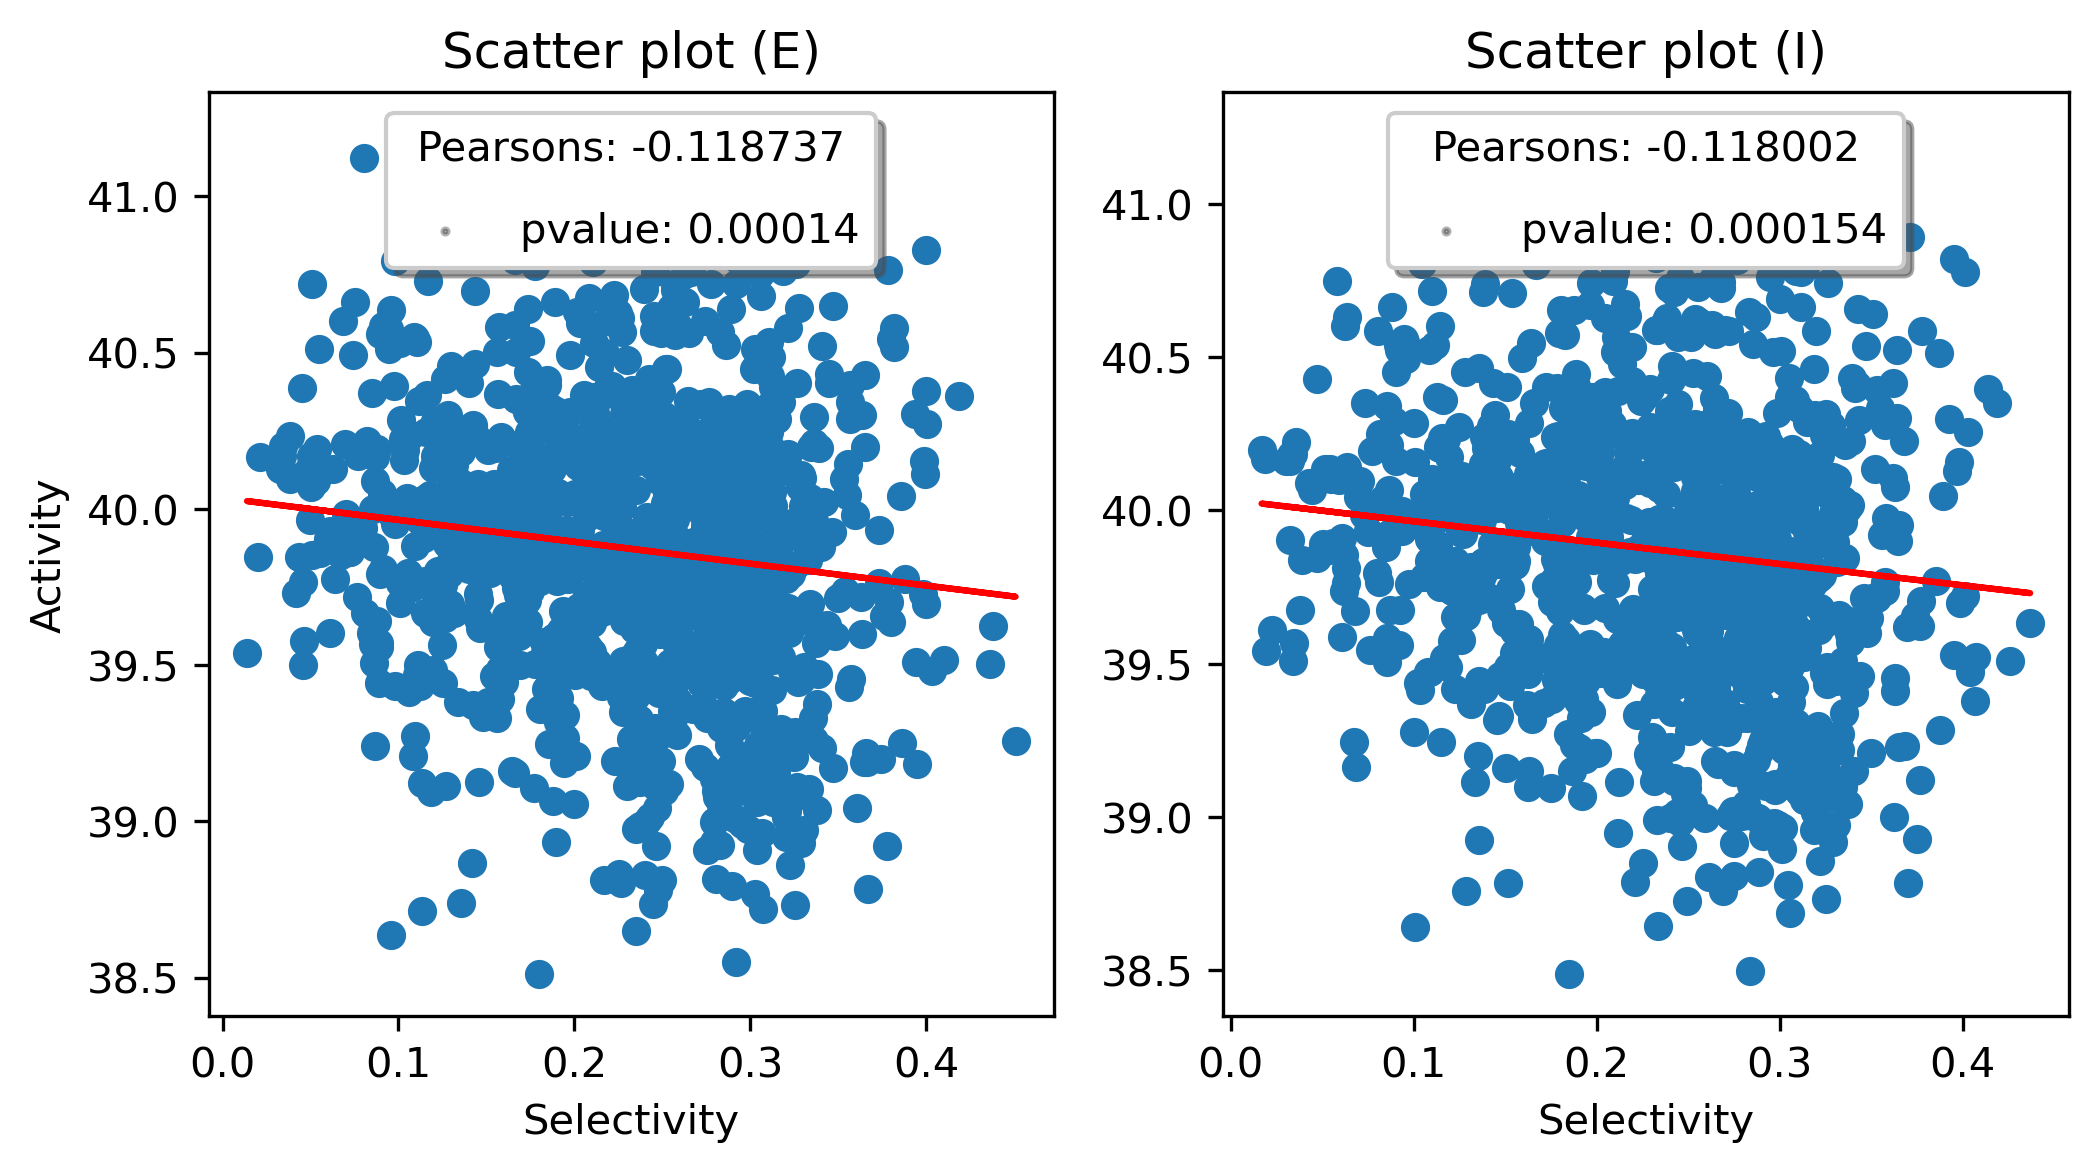

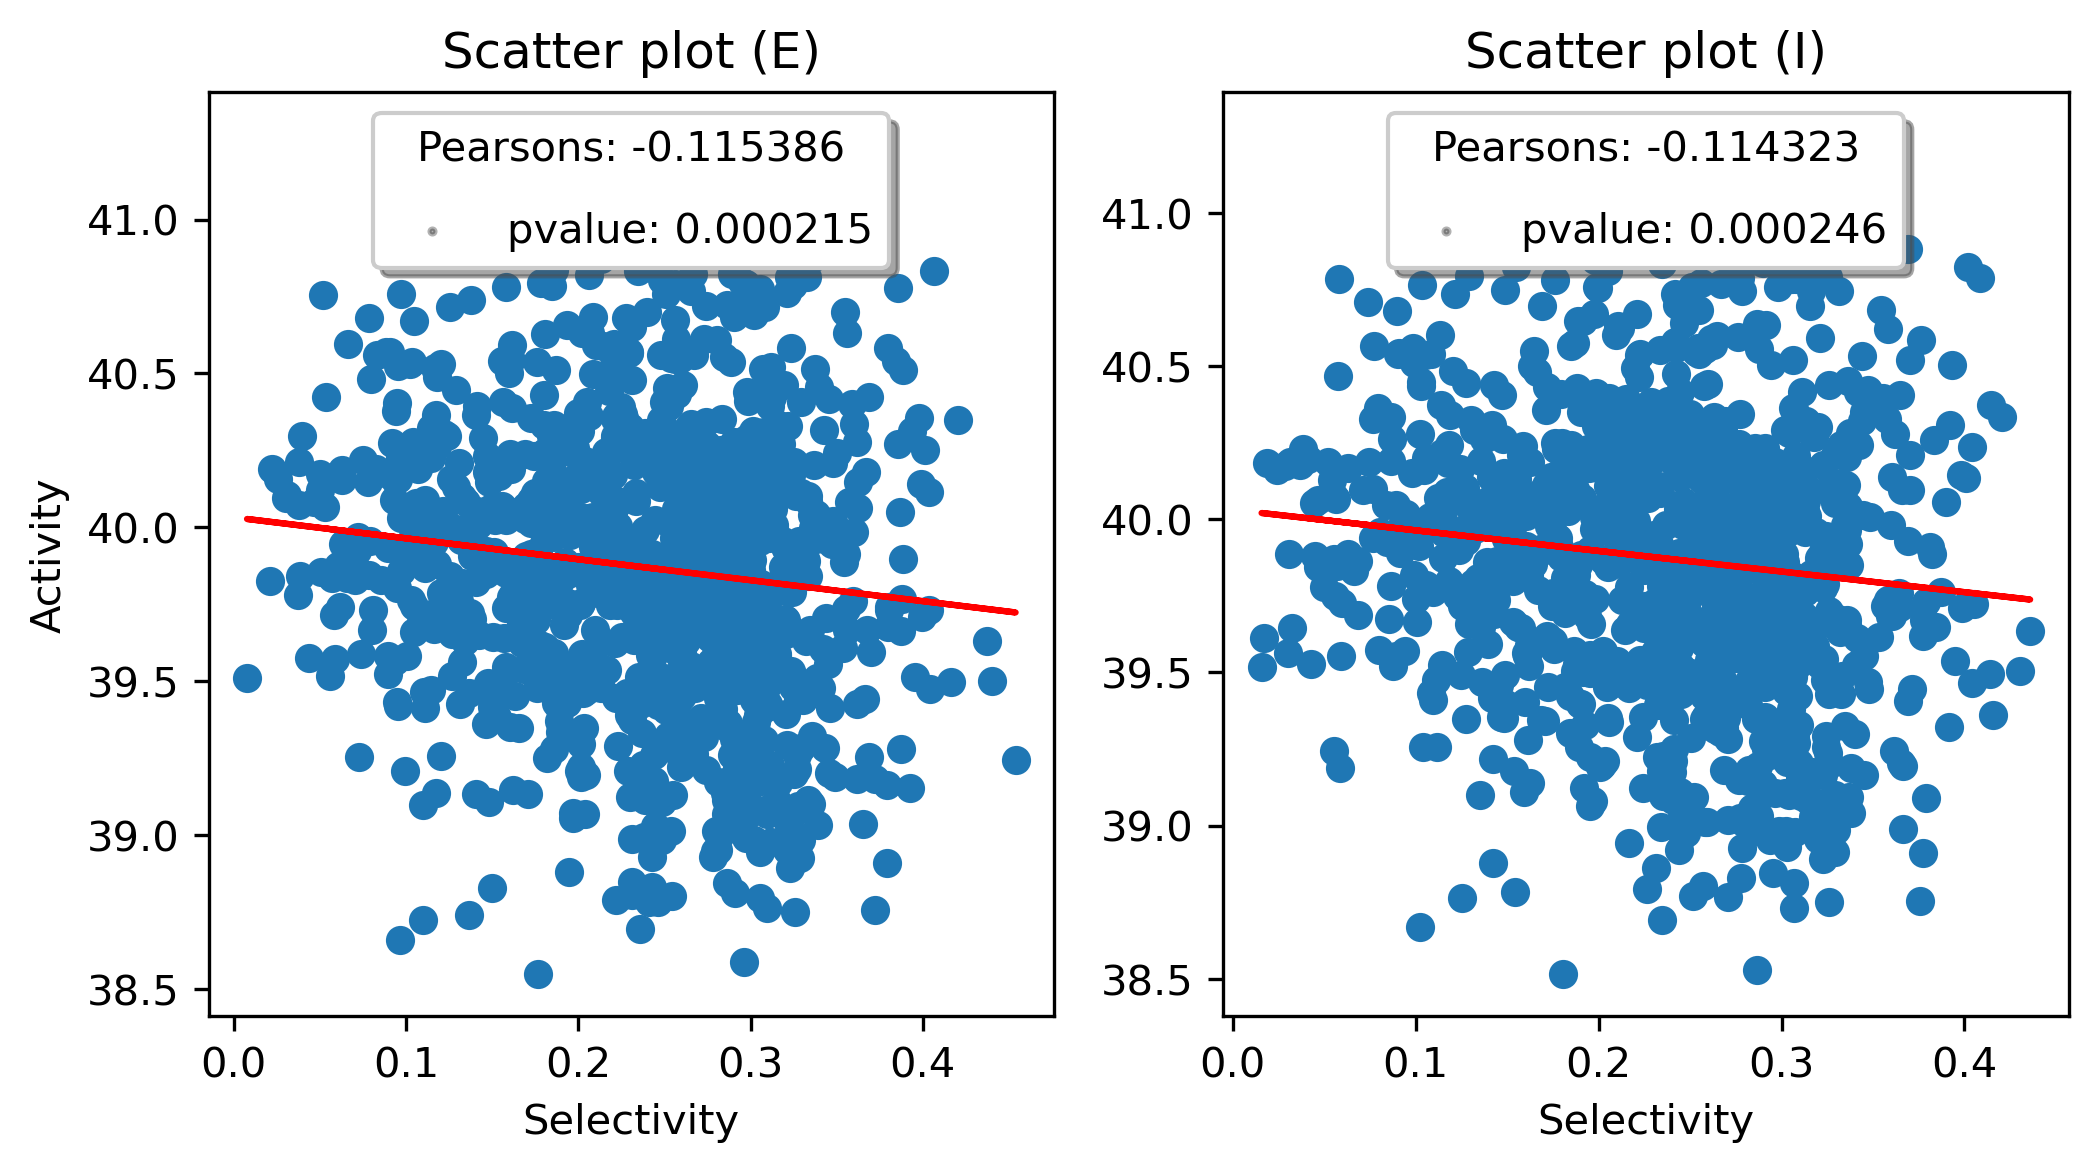

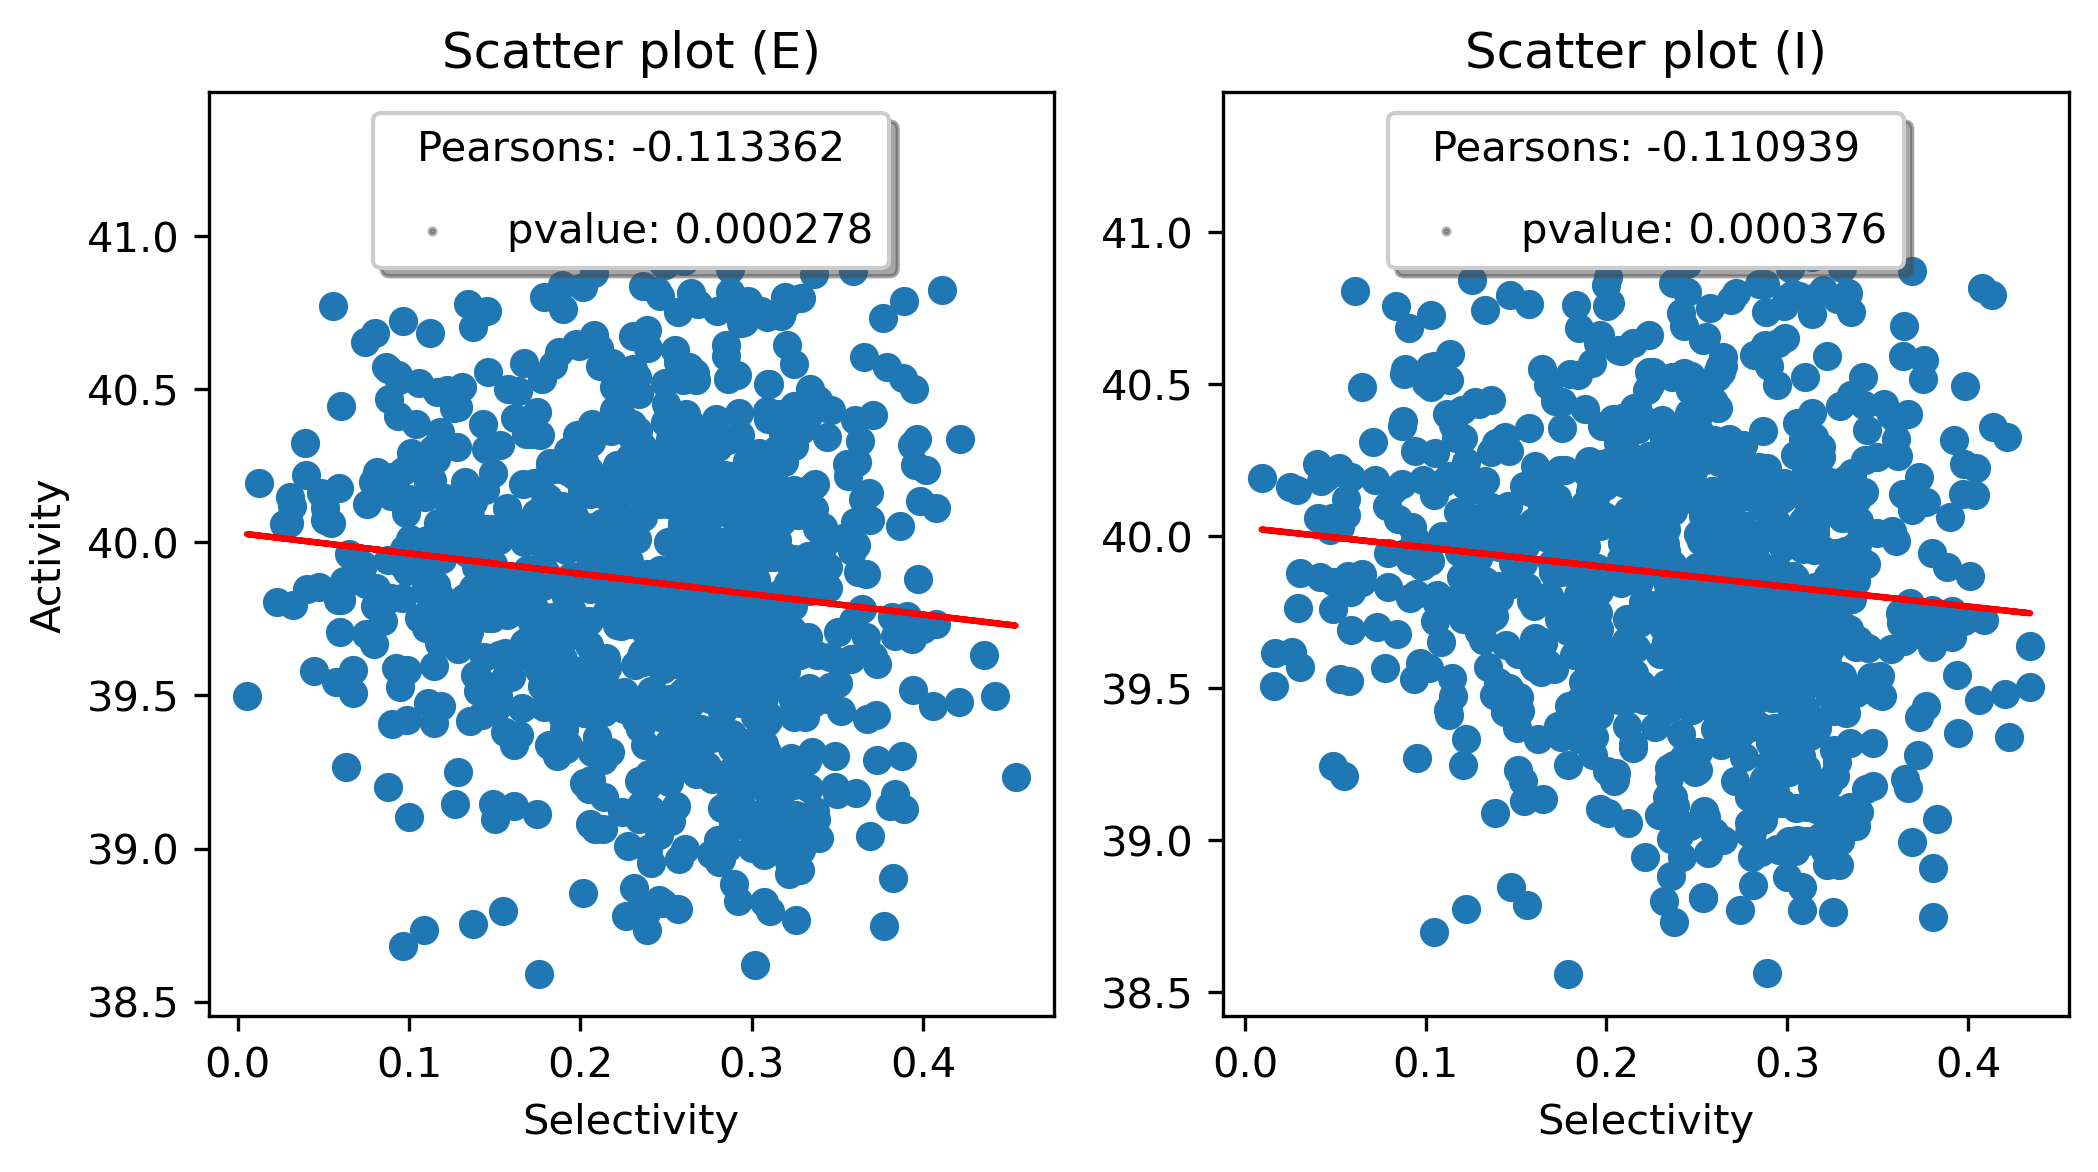

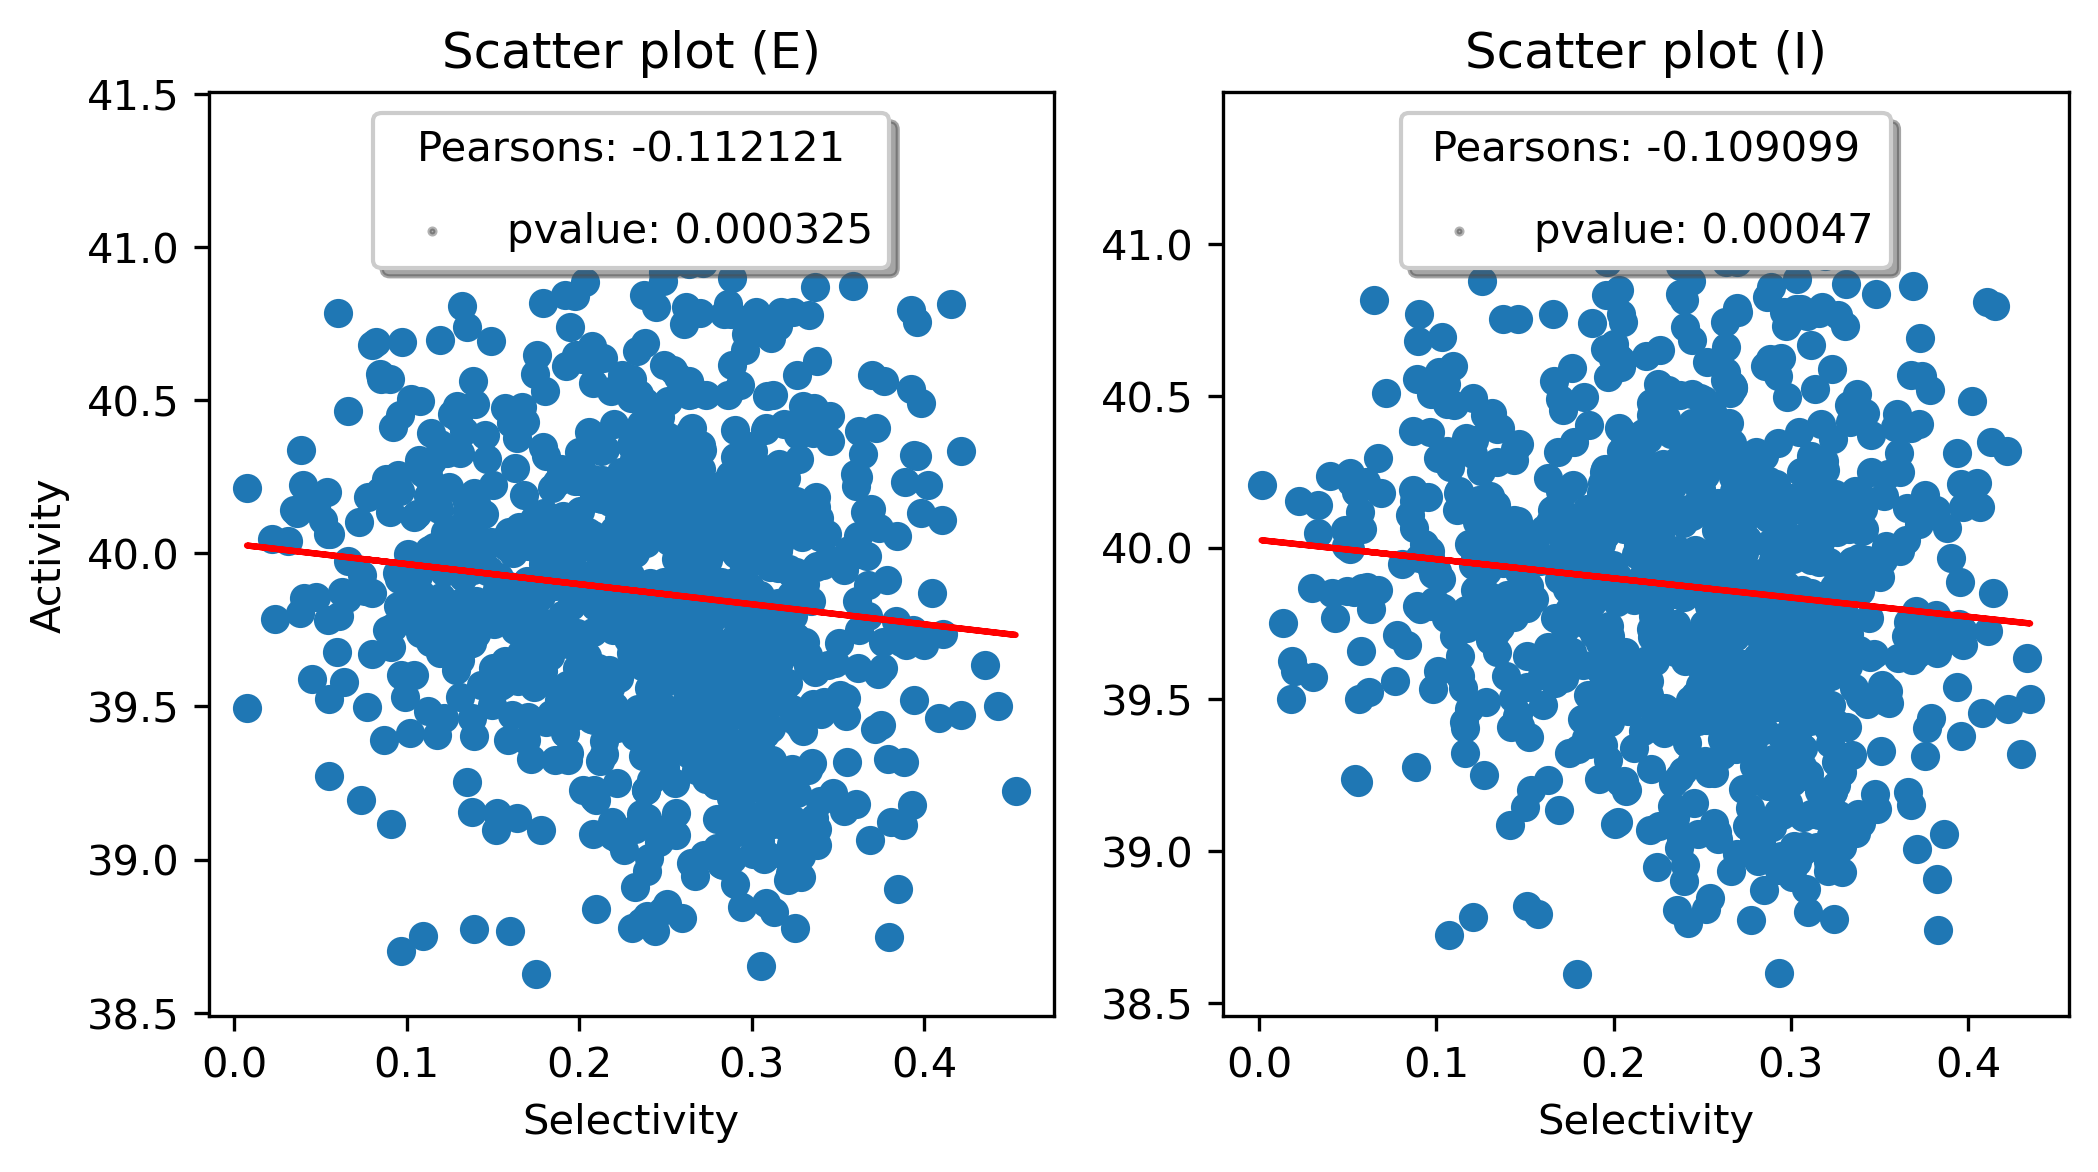

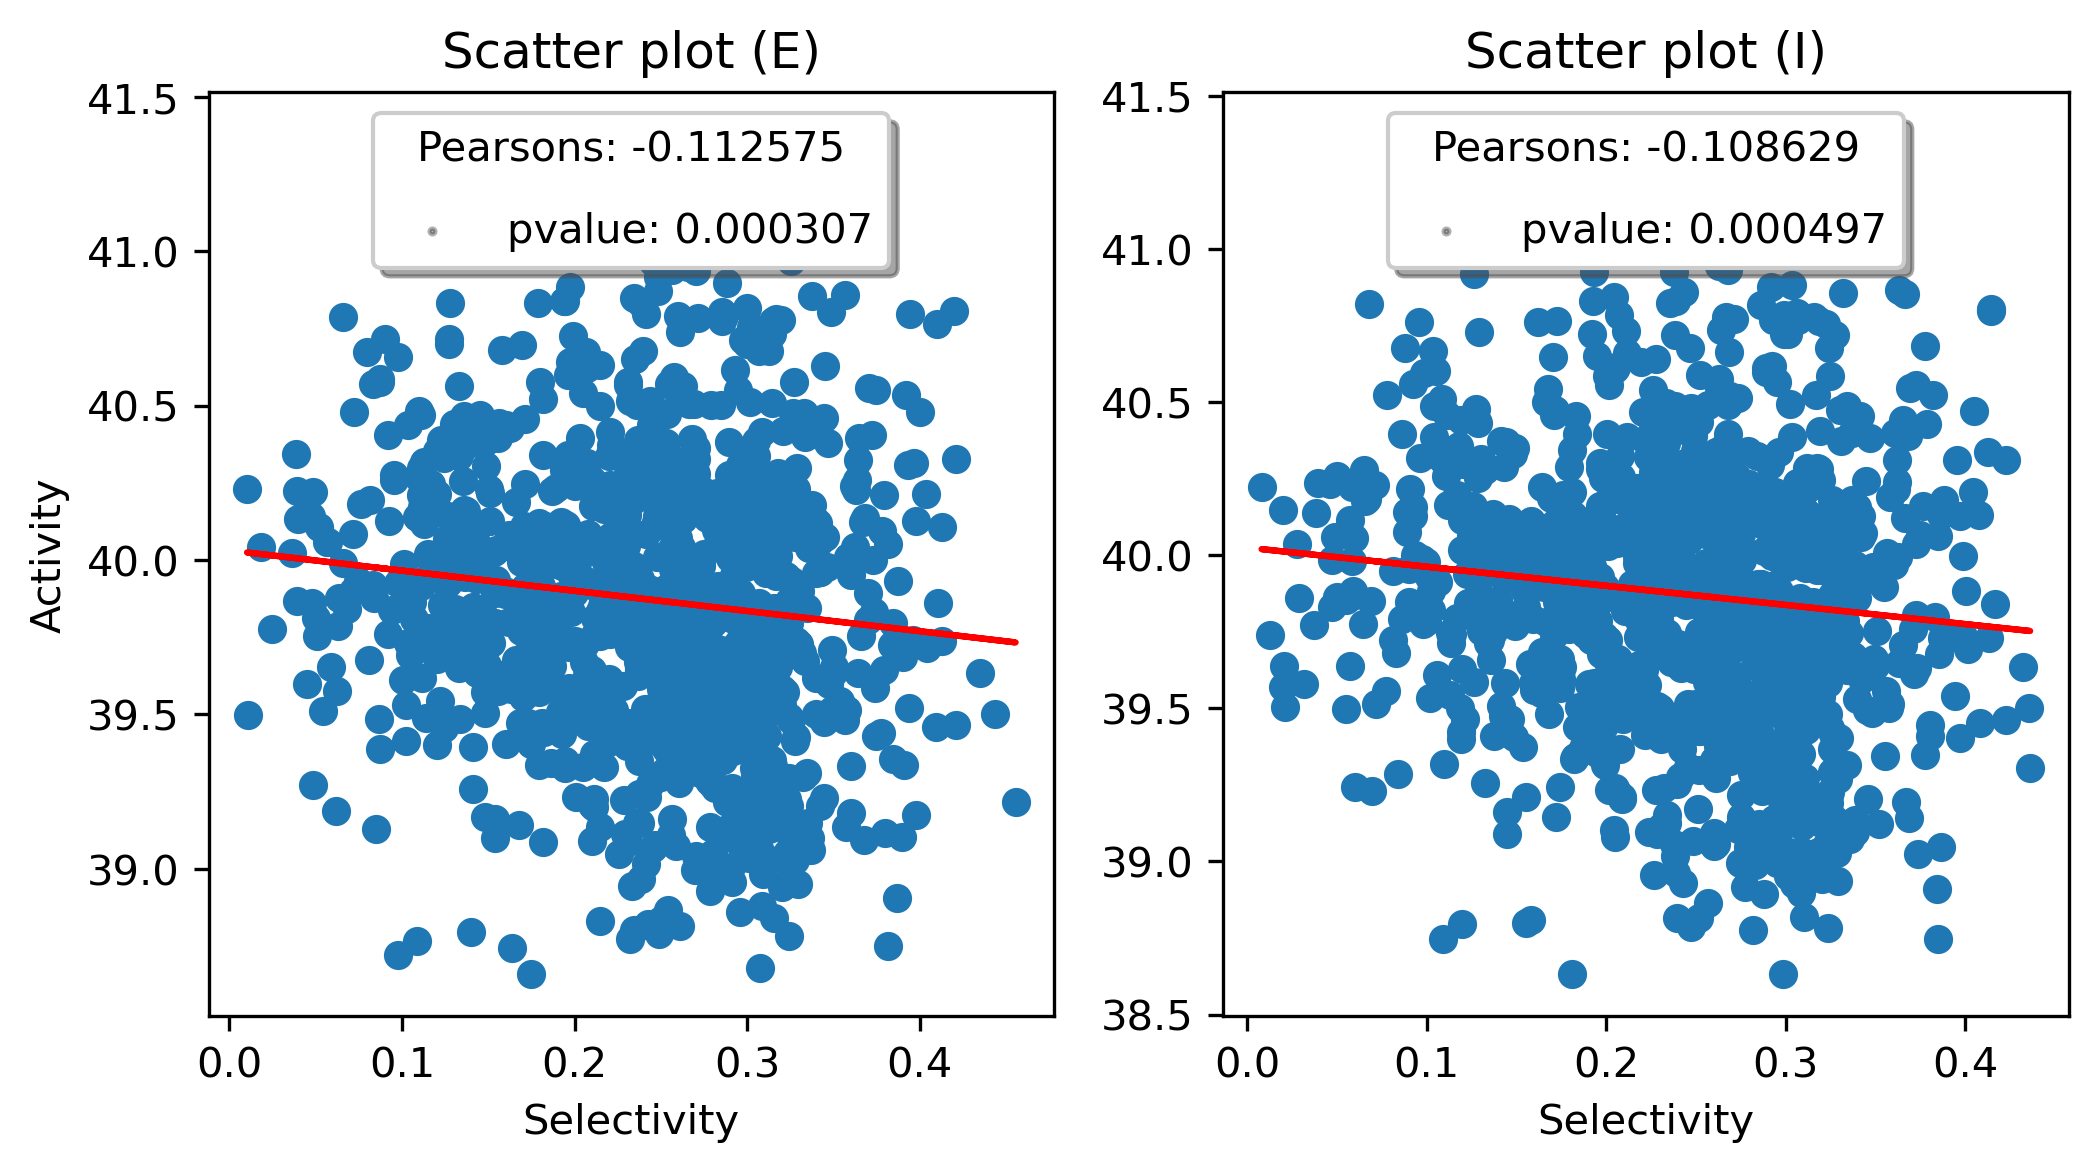

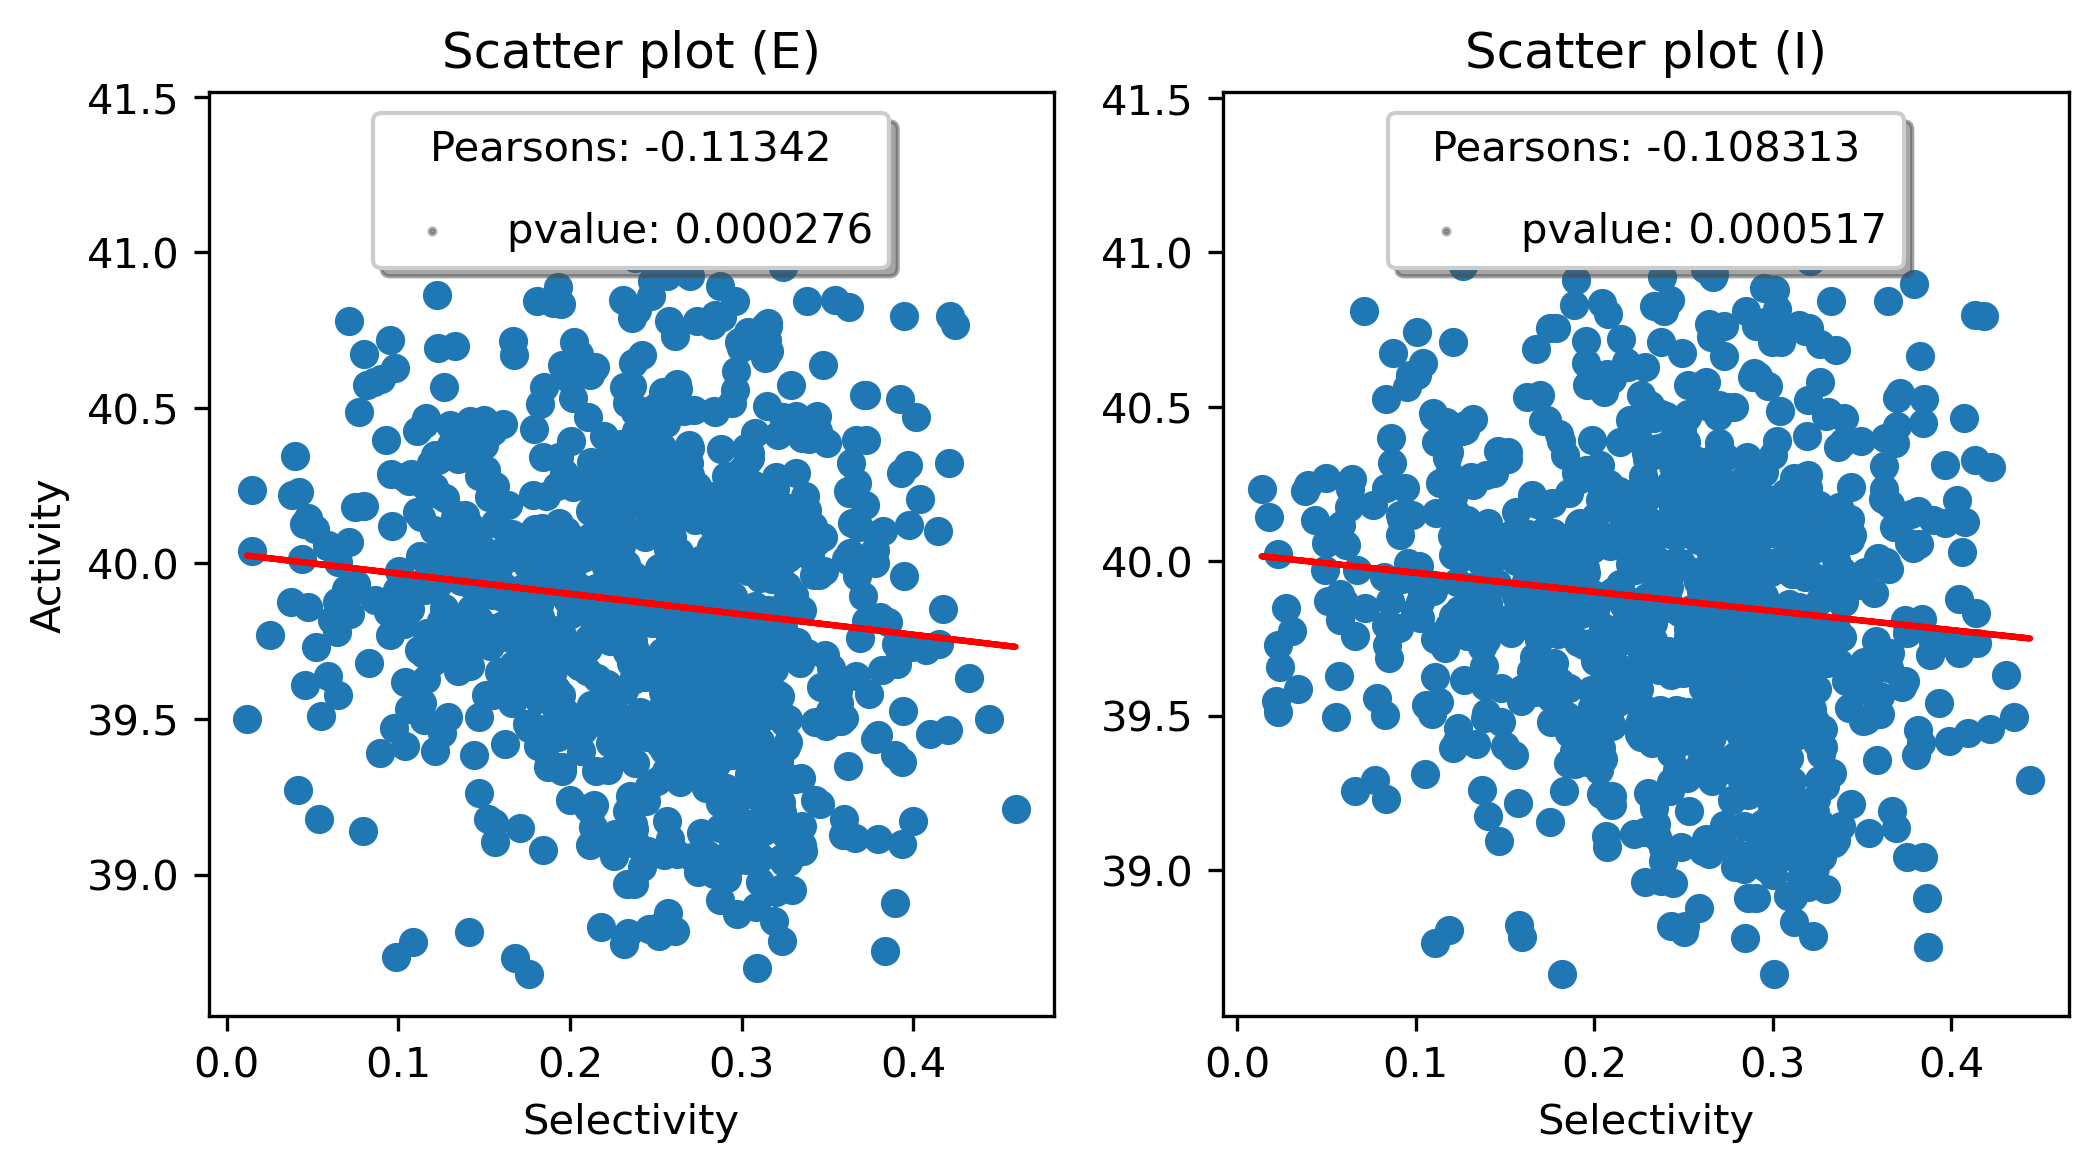

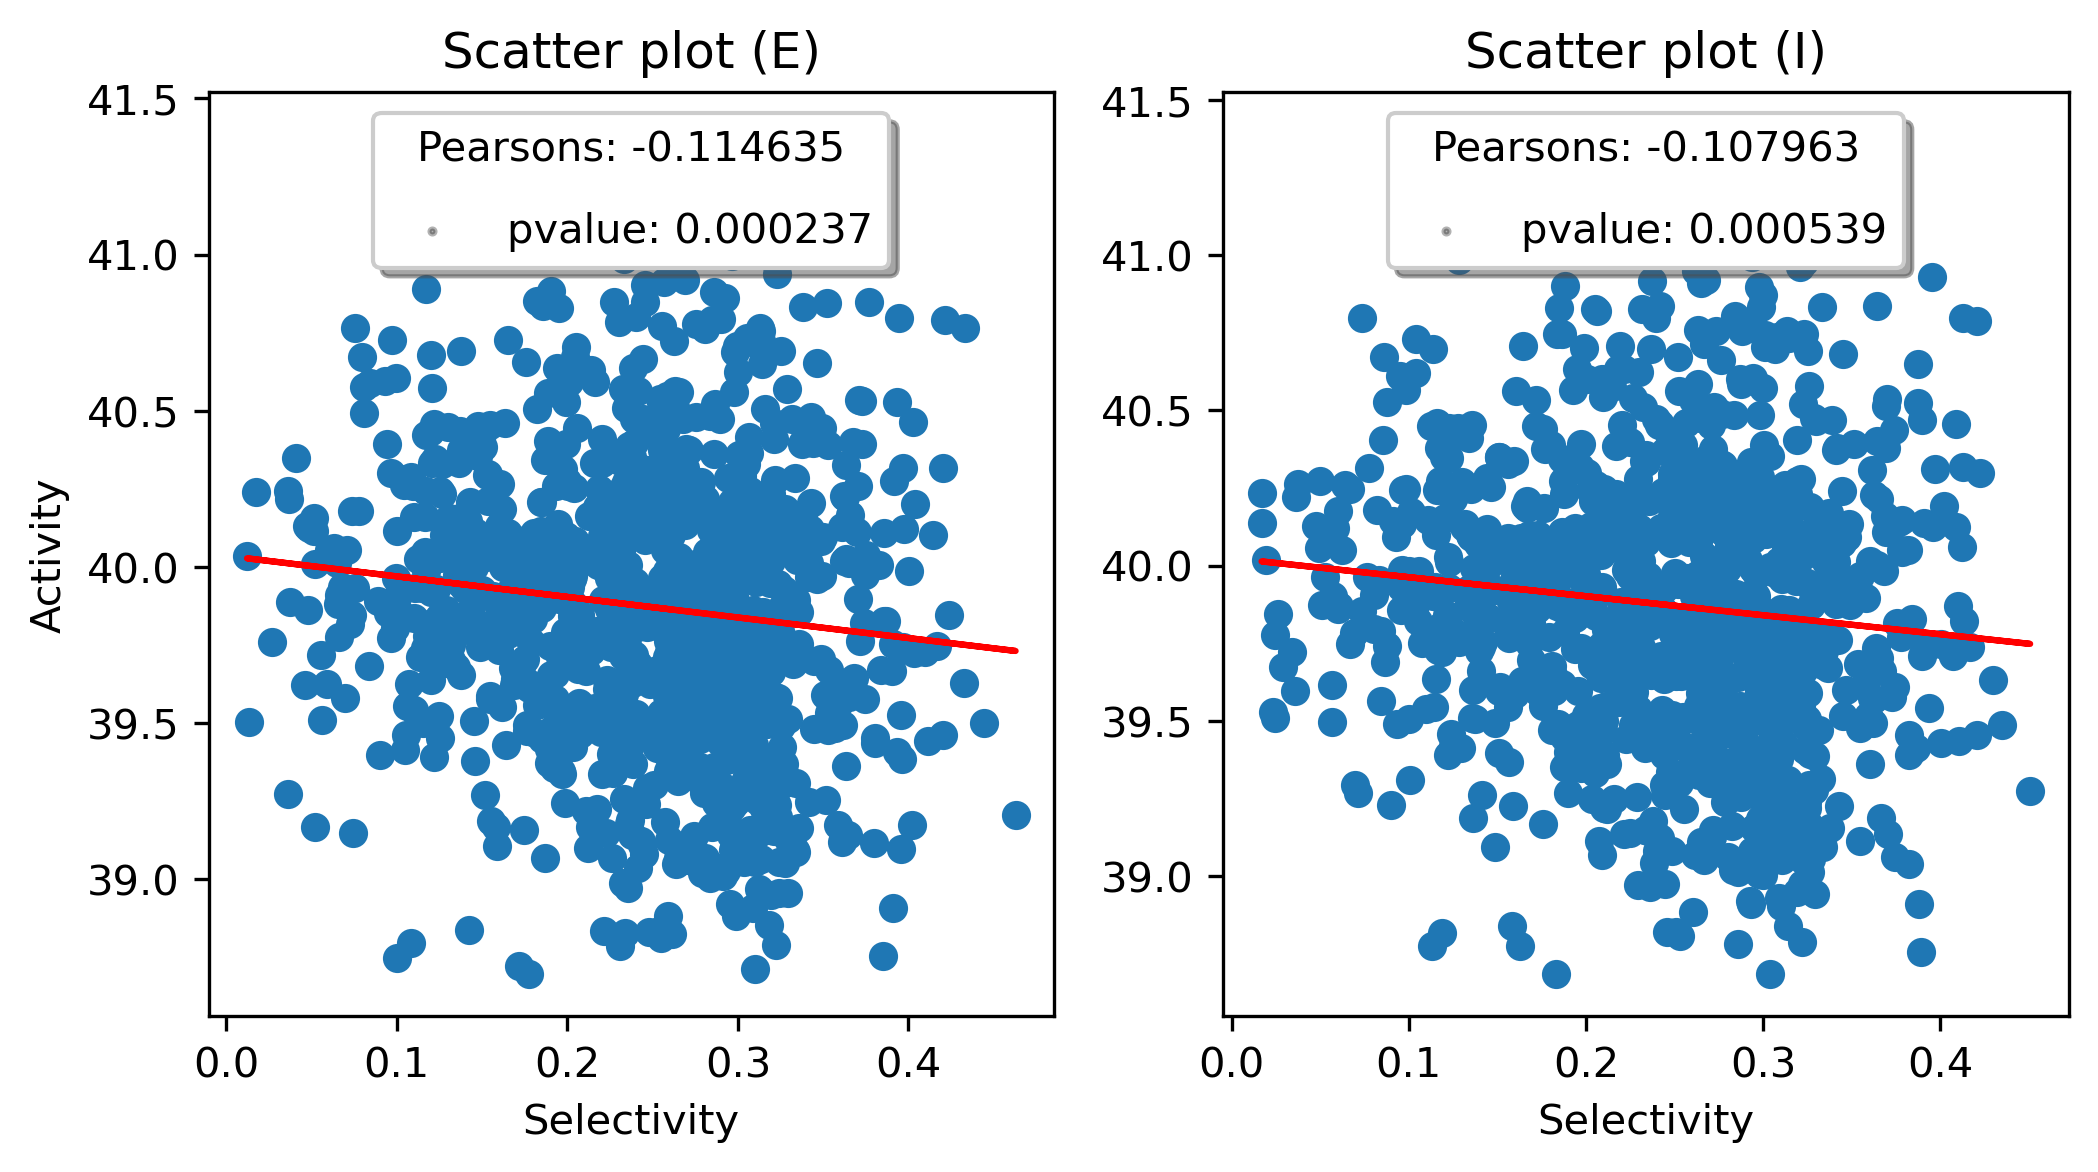

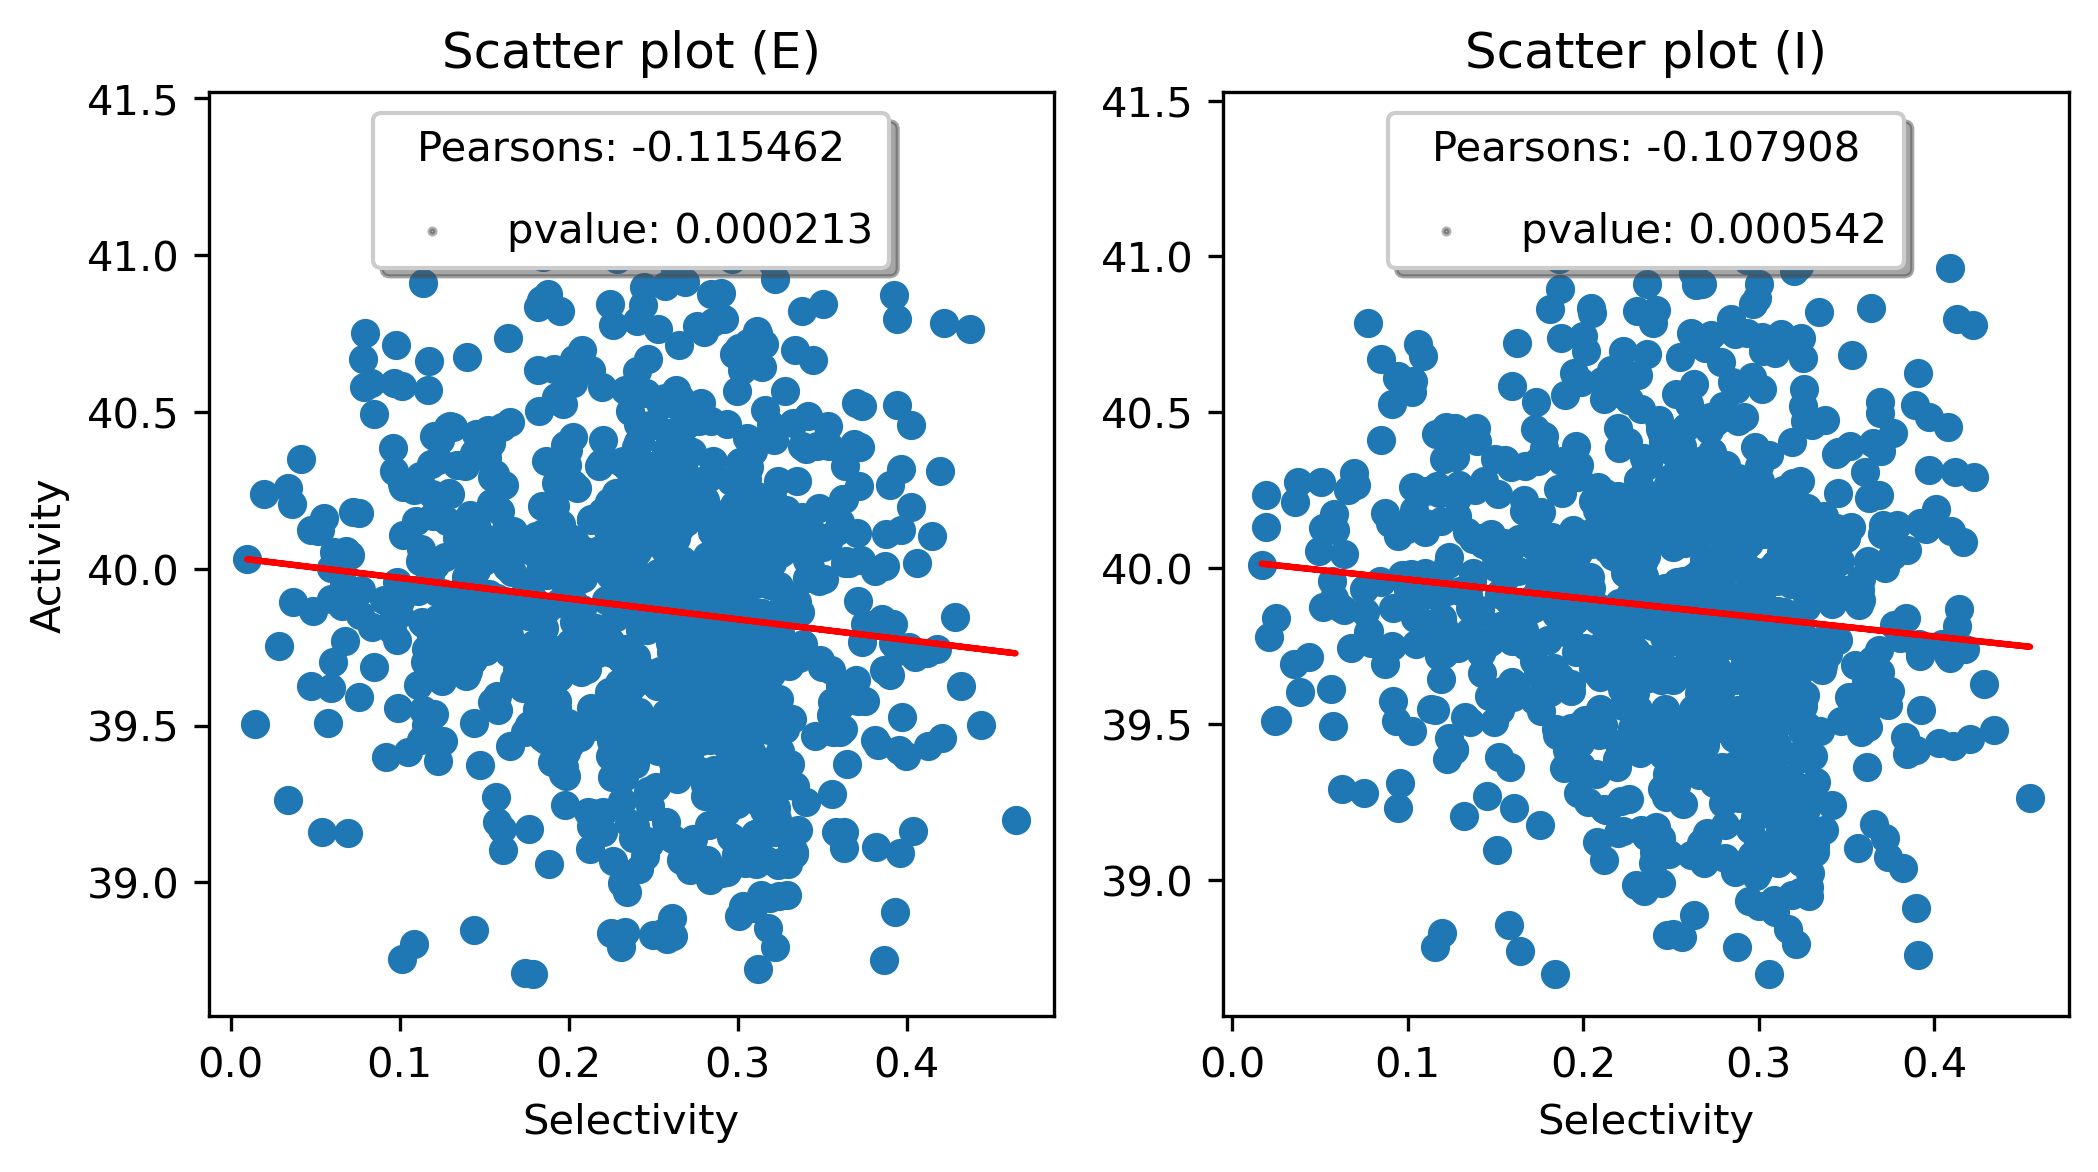

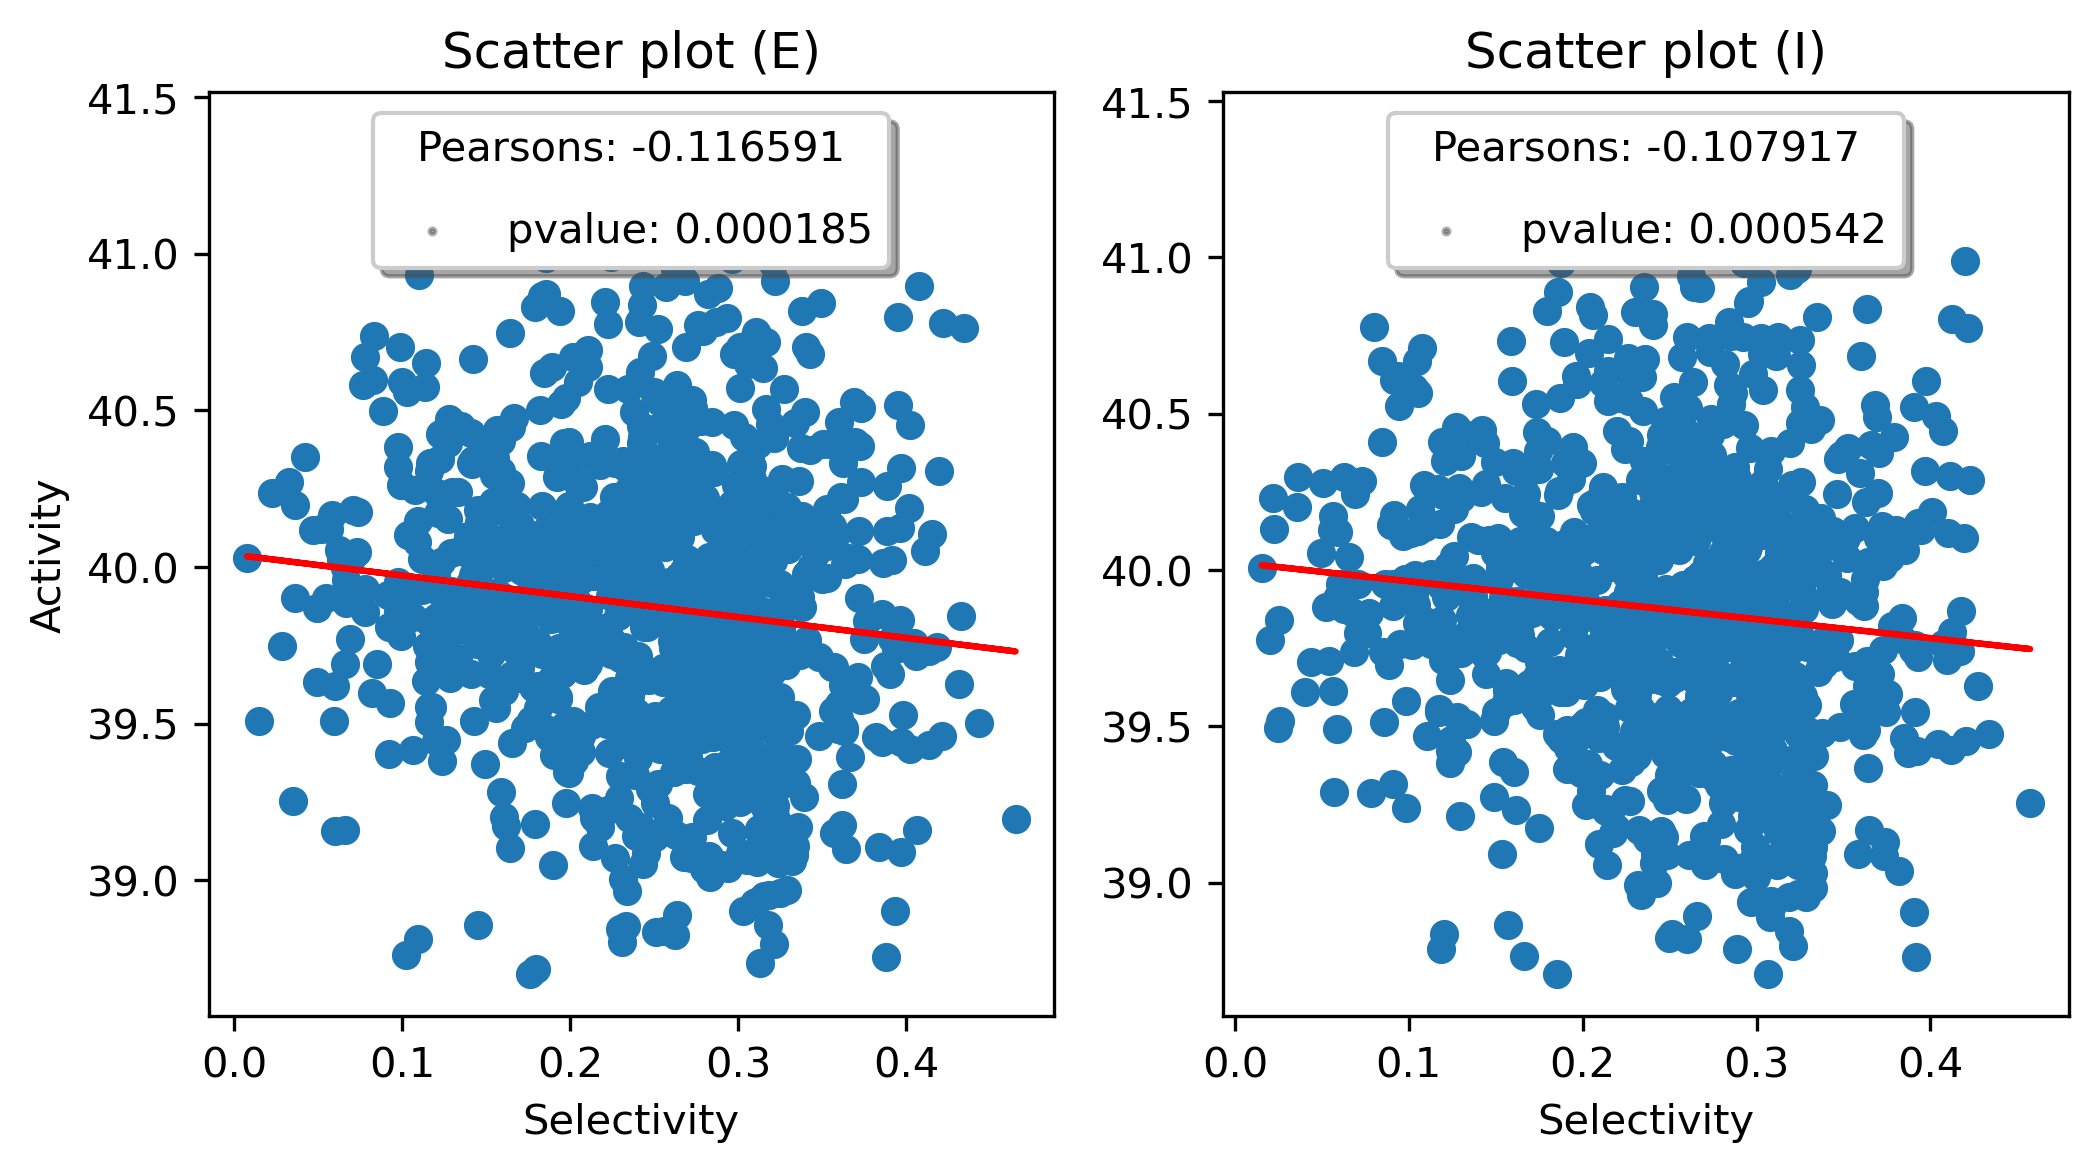

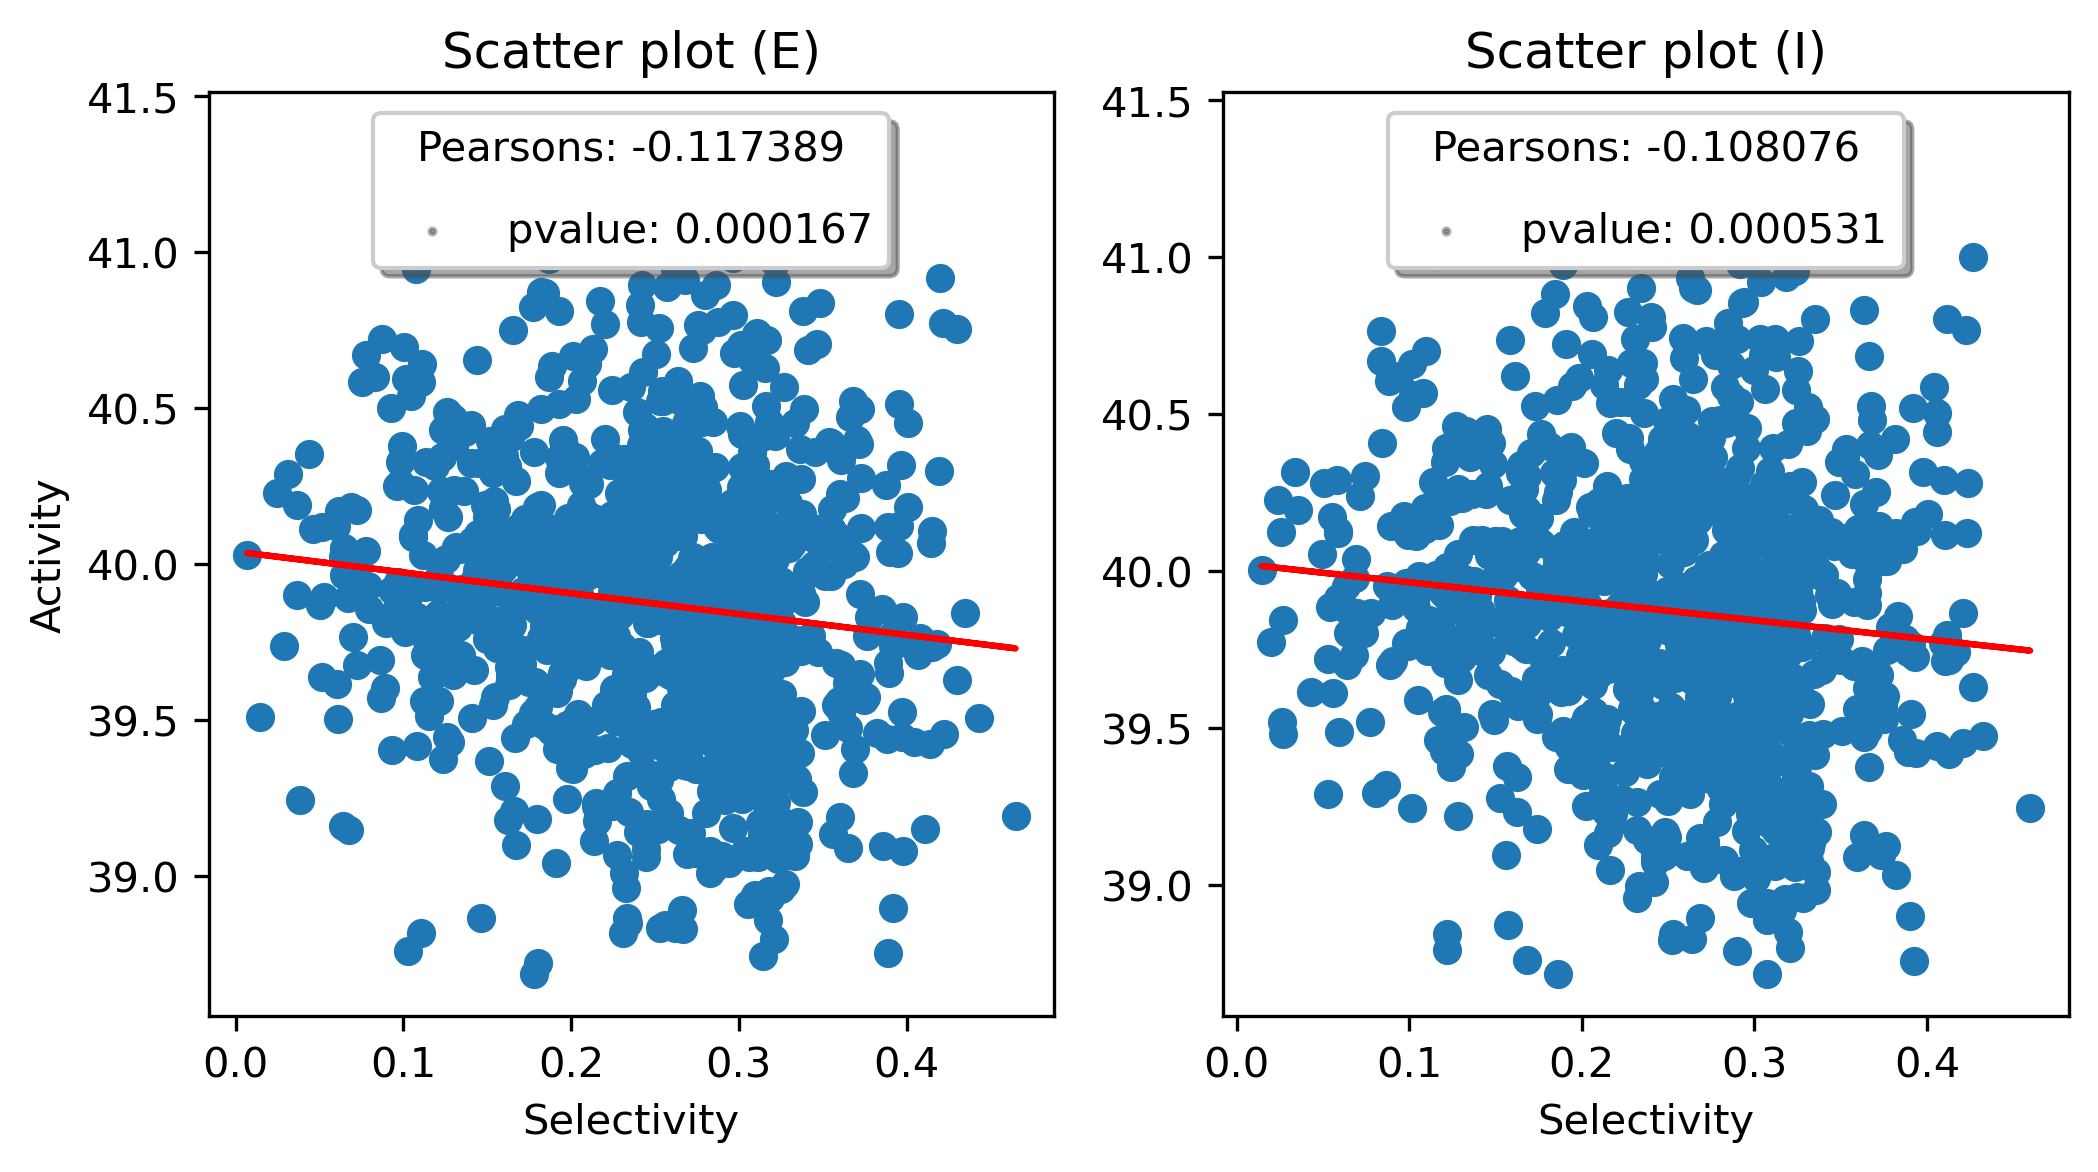

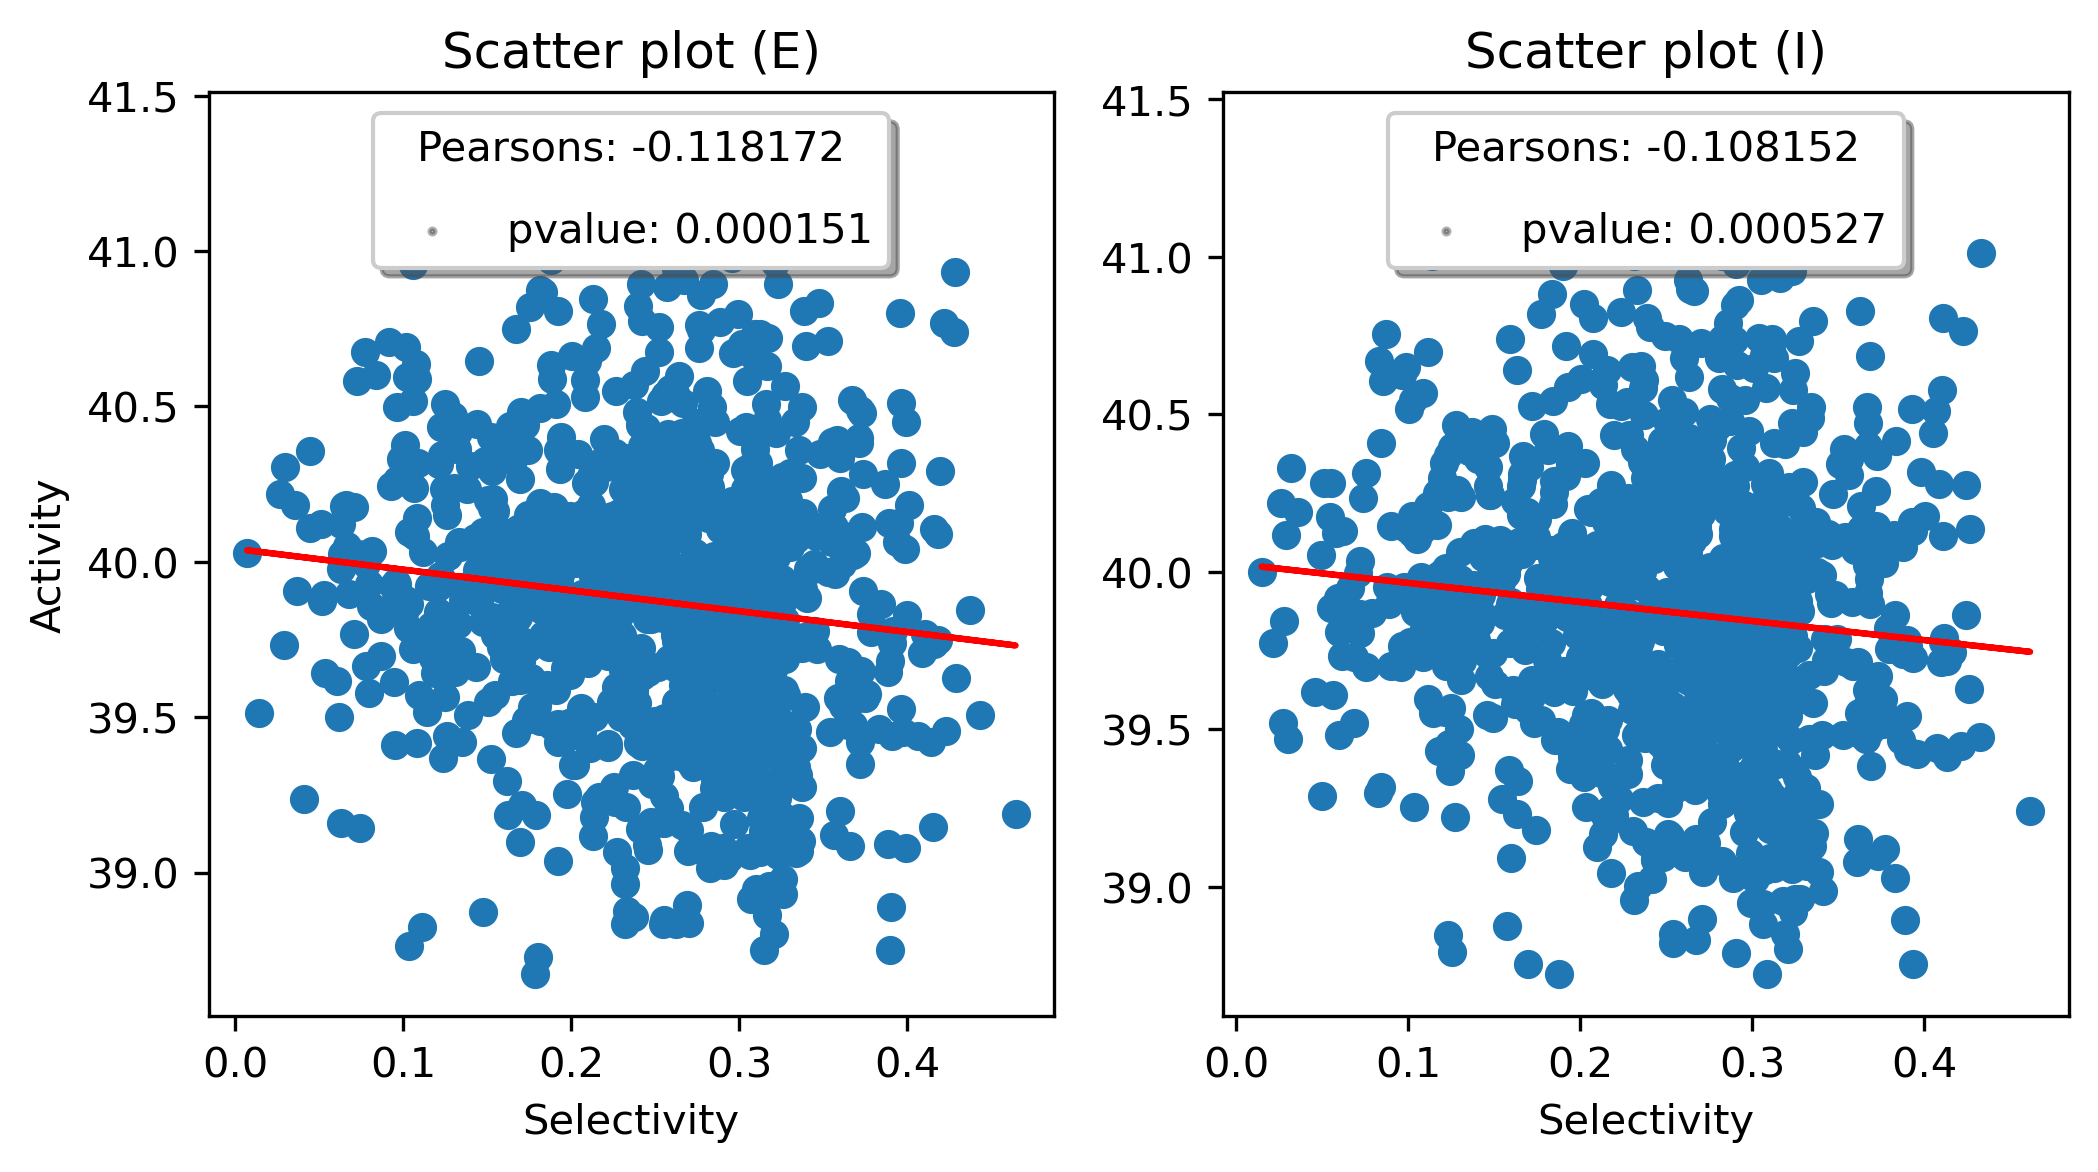

In [14]:
for Version in range(23):
    config_name = 'ffrec_test'
    with np.load('./../dev_ori_sel_RF/data/ffrec/'+config_name+'/v'+str(Version)+'/y_v'+str(Version)+'.npz') as data:
        Wlgn_to_4 = data['W']
        W4_to_4 = data['Wrec']
        l4 = data['l4']
    N4 = int(np.sqrt(W4_to_4.shape[0]//2))
    Nlgn = int(N4)
    DA = 1
    Wlgn_to_4 = Wlgn_to_4.reshape(4,N4*N4,N4*N4)

    fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=300)
    fig.subplots_adjust(hspace=.2, wspace=.2)
    plt.subplot(1,2,1)
    ss_e = Wlgn_to_4[0,...] + Wlgn_to_4[1,...]
    sd_e = Wlgn_to_4[0,...] - Wlgn_to_4[1,...]
    ss_e = ss_e.reshape((N4,N4,Nlgn,Nlgn))
    sd_e = sd_e.reshape((N4,N4,Nlgn,Nlgn))
    opm_e,Rn_e = analysis_tools.get_response(sd_e,DA)
    sel_e = np.abs(opm_e)
    sel_e = sel_e.flatten()
    plt.scatter(sel_e,l4[:N4*N4])
    PEARSON_e,pvalue_e = stats.pearsonr(sel_e, l4[:N4*N4])
    m, b = np.polyfit(sel_e, l4[:N4*N4], 1)
    plt.plot(sel_e, m*sel_e+b, color='red')
    plt.ylabel('Activity')
    plt.xlabel('Selectivity')
    plt.title('Scatter plot (E)')
    plt.scatter([],[],c='k',alpha=0.3,s=2,label='pvalue: ' + str("{0:.3g}".format(pvalue_e)))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=2, fancybox=True, shadow=True,scatterpoints=1, frameon=True, labelspacing=1, title='Pearsons: '+str("{0:.6g}".format(PEARSON_e)))

    plt.subplot(1,2,2)
    ss_i = Wlgn_to_4[2,...] + Wlgn_to_4[3,...]
    sd_i = Wlgn_to_4[2,...] - Wlgn_to_4[3,...]
    ss_i = ss_i.reshape((N4,N4,Nlgn,Nlgn))
    sd_i = sd_i.reshape((N4,N4,Nlgn,Nlgn))
    opm_i,Rn_i = analysis_tools.get_response(sd_i,DA)
    sel_i = np.abs(opm_i)
    sel_i = sel_i.flatten()
    plt.scatter(sel_i,l4[N4*N4:])
    PEARSON_i,pvalue_i = stats.pearsonr(sel_i, l4[N4*N4:])
    m, b = np.polyfit(sel_i, l4[N4*N4:], 1)
    plt.plot(sel_i, m*sel_i+b, color='red')
    plt.xlabel('Selectivity')
    plt.title('Scatter plot (I)')
    plt.scatter([],[],c='k',alpha=0.3,s=2,label='pvalue: ' + str("{0:.3g}".format(pvalue_i)))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=2, fancybox=True, shadow=True,scatterpoints=1, frameon=True, labelspacing=1, title='Pearsons: '+str("{0:.6g}".format(PEARSON_i)))


In [18]:
N4 = l4.shape[0]//2
correlations = np.zeros([4,N4])
pvalues = np.zeros([4,N4])
for i in range(N4): #E to E
    W4to4 = W4_to_4[:N4,:N4]
    l40 = l4[:N4]
    PEARSON,pvalue = stats.pearsonr(W4to4[i,:], l40)
    correlations[0,i] = PEARSON
    pvalues[0,i] = pvalue
for i in range(N4): # E to I
    W4to4 = W4_to_4[N4:,:N4]
    l40 = l4[:N4]
    PEARSON,pvalue = stats.pearsonr(W4to4[i,:], l40)
    correlations[1,i] = PEARSON
    pvalues[1,i] = pvalue
for i in range(N4): # I to E
    W4to4 = -W4_to_4[:N4,N4:]
    l40 = l4[N4:]
    PEARSON,pvalue = stats.pearsonr(W4to4[i,:], l40)
    correlations[2,i] = PEARSON
    pvalues[2,i] = pvalue
for i in range(N4): #I to I
    W4to4 = -W4_to_4[N4:,N4:]
    l40 = l4[N4:]
    PEARSON,pvalue = stats.pearsonr(W4to4[i,:], l40)
    correlations[3,i] = PEARSON
    pvalues[3,i] = pvalue

32


Text(0.5, 1.0, 'Weights/Activity Pvalues (I to I)')

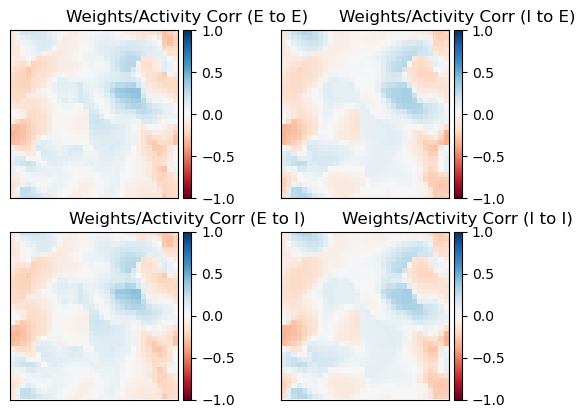

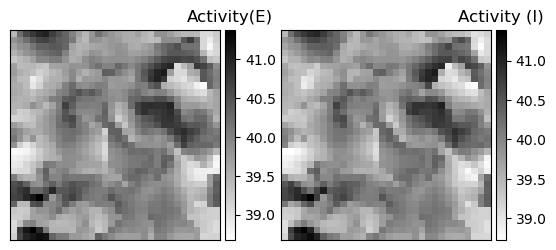

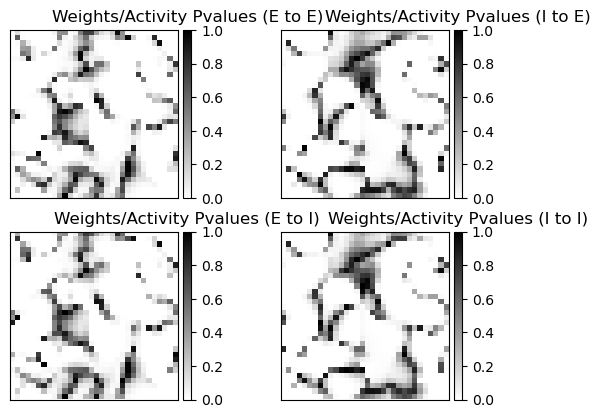

In [21]:
N4s = int(np.sqrt(N4))
print(N4s)
fig,axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.2, wspace=.2)
pf.imshowbar(fig,axs[0,0],correlations[0,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (E to E)')
pf.imshowbar(fig,axs[0,1],correlations[2,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (I to E)')
pf.imshowbar(fig,axs[1,0],correlations[1,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (E to I)')
pf.imshowbar(fig,axs[1,1],correlations[3,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (I to I)')

fig,axs = plt.subplots(1,2)
fig.subplots_adjust(hspace=.2, wspace=.2)
pf.imshowbar(fig,axs[0],l4[:N4].reshape(N4s,N4s),cmap='binary')
plt.title('Activity(E)')
pf.imshowbar(fig,axs[1],l4[N4:].reshape(N4s,N4s),cmap='binary')
plt.title('Activity (I)')

fig,axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.2, wspace=.2)
pf.imshowbar(fig,axs[0,0],pvalues[0,:].reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Weights/Activity Pvalues (E to E)')
pf.imshowbar(fig,axs[0,1],pvalues[2,:].reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Weights/Activity Pvalues (I to E)')
pf.imshowbar(fig,axs[1,0],pvalues[1,:].reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Weights/Activity Pvalues (E to I)')
pf.imshowbar(fig,axs[1,1],pvalues[3,:].reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Weights/Activity Pvalues (I to I)')

['W', 'Wrec', 'l4']


Text(0.5, 1.0, 'Weights/Activity Corr (E to E)')

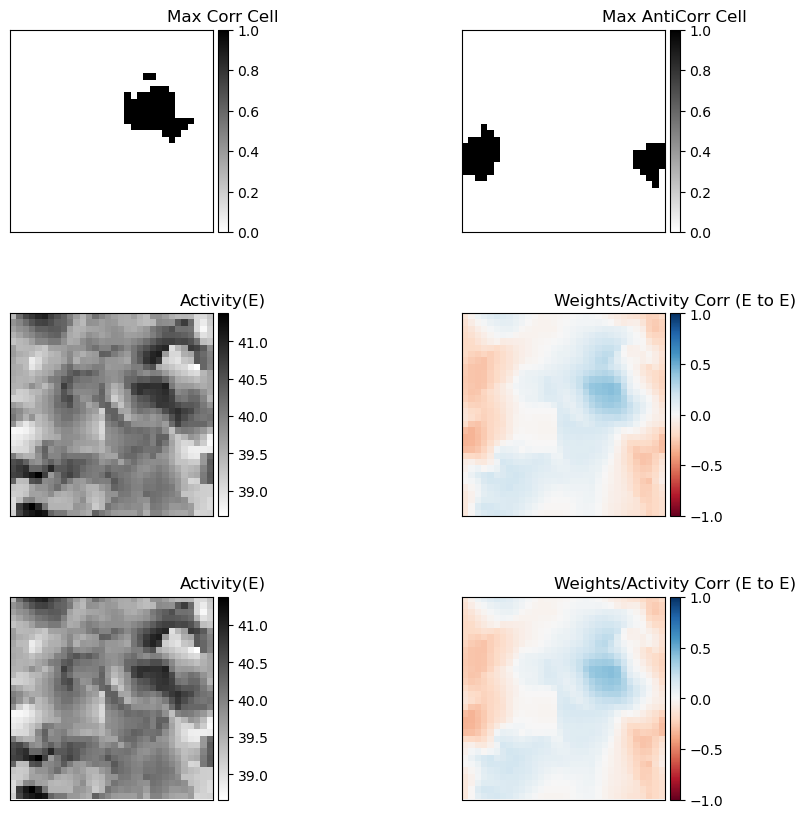

In [55]:
config_name = 'ffrec_test'
Version = 23
with np.load('./../dev_ori_sel_RF/data/ffrec/'+config_name+'/v'+str(Version)+'/y_v'+str(Version)+'.npz') as data:
    print(list(data.keys()))
    Wlgn_to_4 = data['W']
    W4_to_4 = data['Wrec']
    l4 = data['l4']
N4 = l4.shape[0]//2
N4s = int(np.sqrt(N4))
MaxCorrCellEE = np.argmax(correlations[0,:])
MaxAntiCorrCellEE = np.argmin(correlations[0,:])
WtoMax = W4_to_4[MaxCorrCellEE,:N4]
WtoMaxAnti = W4_to_4[MaxAntiCorrCellEE,:N4]
MaxWeigthttoMax = np.max(WtoMax)
MaxWeighttoMaxAnti = np.max(WtoMaxAnti)
r = 0.7
maskmax = WtoMax > MaxWeigthttoMax*r
maskanti = WtoMaxAnti > MaxWeighttoMaxAnti*r
WtoMax[maskmax] = 1
WtoMax[~maskmax] = 0
WtoMaxAnti[maskanti] = 1
WtoMaxAnti[~maskanti] = 0
fig,axs = plt.subplots(3,2,figsize=(10,10))
fig.subplots_adjust(hspace=.4, wspace=.4)
pf.imshowbar(fig,axs[0,0],WtoMax.reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Max Corr Cell')
pf.imshowbar(fig,axs[0,1],WtoMaxAnti.reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Max AntiCorr Cell')
pf.imshowbar(fig,axs[1,0],l4[:N4].reshape(N4s,N4s),cmap='binary')
plt.title('Activity(E)')
pf.imshowbar(fig,axs[1,1],correlations[0,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (E to E)')
pf.imshowbar(fig,axs[2,0],l4[:N4].reshape(N4s,N4s),cmap='binary')
plt.title('Activity(E)')
pf.imshowbar(fig,axs[2,1],correlations[0,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (E to E)')

In [3]:
def get_network_size(config_name):
    config_dict = misc.load_external_params("params_"+config_name)
    config_dict.update({"config_name" : config_name})

    N4 = config_dict["N4"]
    Nlgn = config_dict["Nlgn"]
    Nret = config_dict["Nret"]
    Nlgnpop = 2
    N4pop = config_dict["num_lgn_paths"] // Nlgnpop
    
    return config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4

def get_network_system(Version,config_name):
    if Version == -1:
        config_dict = misc.load_external_params("params_"+config_name,False)
        config_dict.update({
                        "RF_mode" : "initialize",
                        "system" : "one_layer",
                        "Version" : Version,
                        })
        net = network.Network(Version,config_dict,verbose=False)
    else:
        load_location = 'local'
        load_path = data_dir + "layer4/{s}/v{v}/".format(s=config_name,v=Version)
        config_dict = pickle.load(open(load_path + "config_v{v}.p".format(v=Version),"rb"))
        config_dict.update({"config_name" : config_name})
        config_dict["Wlgn_to4_params"].update({
            "W_mode": "load_from_external",
            "load_from_prev_run" : Version})
        net = network.Network(Version,config_dict,load_location=load_location,verbose=False)
    return net.system

In [27]:
reload(run_full_plastic)
reload(integrator_tf)

config_name = "ffrec_test"

config_dict,N4pop,Nlgnpop,Nret,Nlgn,N4 = get_network_size(config_name)
config_dict.update({"config_name" : config_name,
                    "saving_stepsize" : 1,
                    "runtime" : 6*125})

Version = 25
run_full_plastic.parameter_sweep_ffrec(Version,config_dict,not_saving_temp=True)

Default GPU Device: /device:GPU:0
MISC params_dict params_ffrec_test {'Nret': 32, 'Nlgn': 32, 'N4': 32, 'N23': 1, 'Nvert': 1, 'runtime': 32000, 'dt': 0.05, 'tau': 1.0, 'num_lgn_paths': 4, 'gamma_lgn': 4.0, 'gamma_4': 1.0, 'gamma_23': 1.0, 'learning_rate_decay_const': 160000.0, 'saving_stepsize': 10, 'plasticity_rule': 'activity_based', 'random_seed': 19, 'nonlinearity_l4': 'rectifier', 'nonlinearity_l23': 'rectifier', 'integrator': 'Euler', 'test_lowDsubset': False, 'developing_params': [], 'q_dict': True, 'Inp_params': {'ndim': 25, 'radius': 3.0, 'width': 1.0, 'simulate_activity': 'dynamics', 'pattern_duration': 2500, 'avg_no_inp': 1, 'expanse_time': 1, 'init_radius': 0.3, 'mean_width': 0.3, 'onoff_corr_factor': 1.0, 'onoff_rel_weight': 1.0, 'input_type': 'white_noise_online', 'off_bias_strength': 0.0, 'off_bias_region_size': 0.5}, 'Wret_to_lgn_params': {'sigma1': 0.0225, 'sigma2': 0.06, 'ampl1': 2.0, 'ampl2': 1.0, 'gamma_ret': 1.0, 'noise': 0.0, 'sigma': 0.03375, 'ampl': 1.0, 'profil

KeyboardInterrupt: 

In [39]:
config_name = 'ffrec_test'
l4t = np.zeros([23,2048])
Wlgn_to_4t = np.zeros([23,4194304])
W4_to_4t = np.zeros([23,2048,2048])
for Version in range(23):
    with np.load('./../dev_ori_sel_RF/data/ffrec/'+config_name+'/v'+str(Version)+'/y_v'+str(Version)+'.npz') as data:
        Wlgn_to_4t[Version,:] = data['W']
        W4_to_4t[Version,:] = data['Wrec']
        l4t[Version,:] = data['l4']
W4_to_4 = np.average(W4_to_4t,axis=0)
Wlgn_to_4 = np.average(Wlgn_to_4t,axis=0)
l4 = np.average(l4t,axis=0)

/Users/alex/Desktop/Columbia/Ken Miller/Codes/SSB/OrientationSSB/notebooks/./../dev_ori_sel_RF/tools/analysis_tools.py:315: RuntimeWarning: invalid value encountered in multiply
  Rn = np.empty((180//delta_bins,N4,N4*Nvert))*np.nan


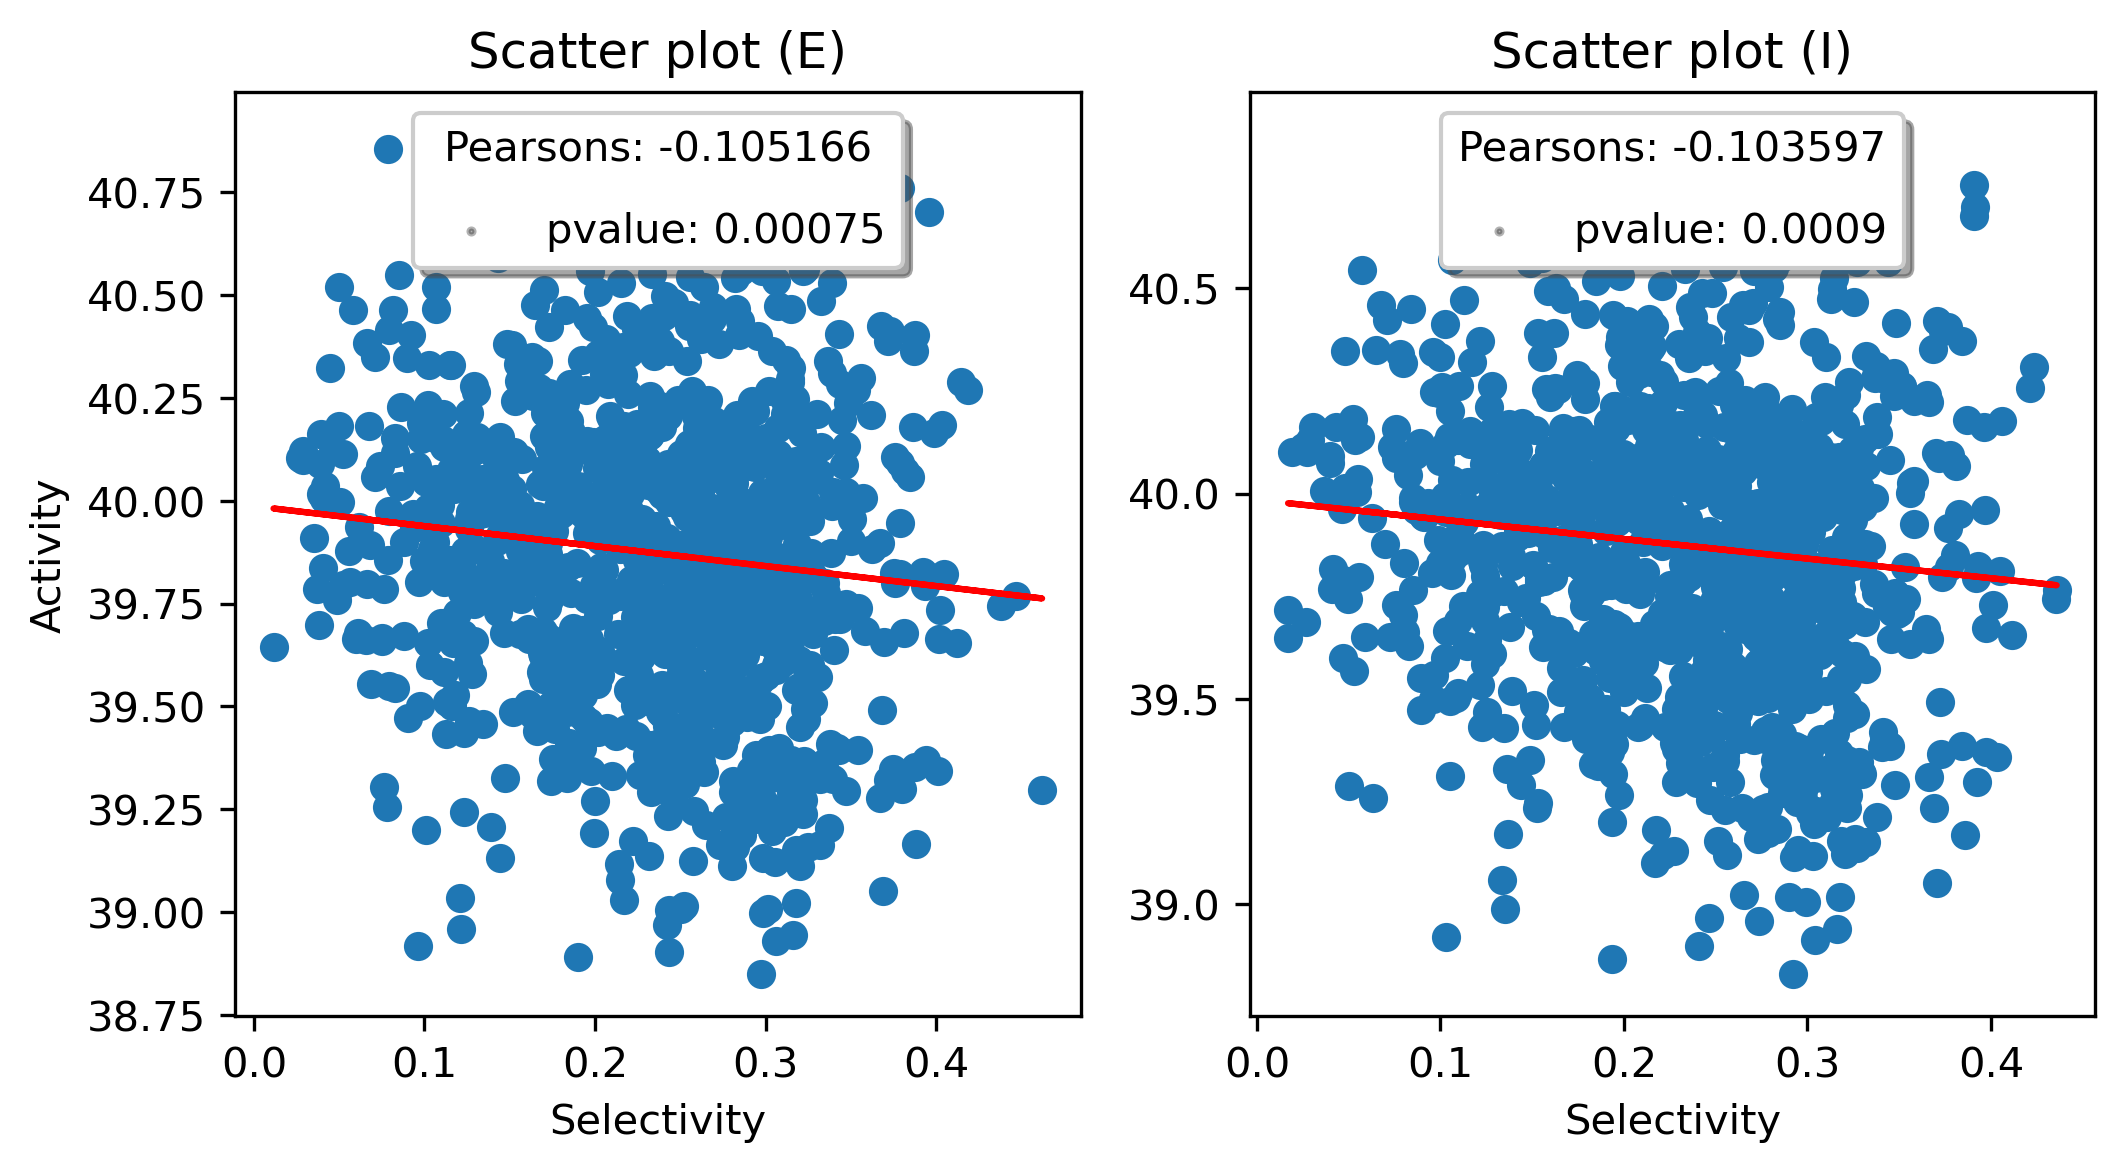

In [41]:
N4 = int(np.sqrt(W4_to_4.shape[0]//2))
Nlgn = int(N4)
DA = 1
Wlgn_to_4 = Wlgn_to_4.reshape(4,N4*N4,N4*N4)

fig,axs = plt.subplots(1,2,figsize=(8,4),dpi=300)
fig.subplots_adjust(hspace=.2, wspace=.2)
plt.subplot(1,2,1)
ss_e = Wlgn_to_4[0,...] + Wlgn_to_4[1,...]
sd_e = Wlgn_to_4[0,...] - Wlgn_to_4[1,...]
ss_e = ss_e.reshape((N4,N4,Nlgn,Nlgn))
sd_e = sd_e.reshape((N4,N4,Nlgn,Nlgn))
opm_e,Rn_e = analysis_tools.get_response(sd_e,DA)
sel_e = np.abs(opm_e)
sel_e = sel_e.flatten()
plt.scatter(sel_e,l4[:N4*N4])
PEARSON_e,pvalue_e = stats.pearsonr(sel_e, l4[:N4*N4])
m, b = np.polyfit(sel_e, l4[:N4*N4], 1)
plt.plot(sel_e, m*sel_e+b, color='red')
plt.ylabel('Activity')
plt.xlabel('Selectivity')
plt.title('Scatter plot (E)')
plt.scatter([],[],c='k',alpha=0.3,s=2,label='pvalue: ' + str("{0:.3g}".format(pvalue_e)))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=2, fancybox=True, shadow=True,scatterpoints=1, frameon=True, labelspacing=1, title='Pearsons: '+str("{0:.6g}".format(PEARSON_e)))

plt.subplot(1,2,2)
ss_i = Wlgn_to_4[2,...] + Wlgn_to_4[3,...]
sd_i = Wlgn_to_4[2,...] - Wlgn_to_4[3,...]
ss_i = ss_i.reshape((N4,N4,Nlgn,Nlgn))
sd_i = sd_i.reshape((N4,N4,Nlgn,Nlgn))
opm_i,Rn_i = analysis_tools.get_response(sd_i,DA)
sel_i = np.abs(opm_i)
sel_i = sel_i.flatten()
plt.scatter(sel_i,l4[N4*N4:])
PEARSON_i,pvalue_i = stats.pearsonr(sel_i, l4[N4*N4:])
m, b = np.polyfit(sel_i, l4[N4*N4:], 1)
plt.plot(sel_i, m*sel_i+b, color='red')
plt.xlabel('Selectivity')
plt.title('Scatter plot (I)')
plt.scatter([],[],c='k',alpha=0.3,s=2,label='pvalue: ' + str("{0:.3g}".format(pvalue_i)))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0),
          ncol=2, fancybox=True, shadow=True,scatterpoints=1, frameon=True, labelspacing=1, title='Pearsons: '+str("{0:.6g}".format(PEARSON_i)))

In [42]:
N4 = l4.shape[0]//2
correlations = np.zeros([4,N4])
pvalues = np.zeros([4,N4])
for i in range(N4): #E to E
    W4to4 = W4_to_4[:N4,:N4]
    l40 = l4[:N4]
    PEARSON,pvalue = stats.pearsonr(W4to4[i,:], l40)
    correlations[0,i] = PEARSON
    pvalues[0,i] = pvalue
for i in range(N4): # E to I
    W4to4 = W4_to_4[N4:,:N4]
    l40 = l4[:N4]
    PEARSON,pvalue = stats.pearsonr(W4to4[i,:], l40)
    correlations[1,i] = PEARSON
    pvalues[1,i] = pvalue
for i in range(N4): # I to E
    W4to4 = -W4_to_4[:N4,N4:]
    l40 = l4[N4:]
    PEARSON,pvalue = stats.pearsonr(W4to4[i,:], l40)
    correlations[2,i] = PEARSON
    pvalues[2,i] = pvalue
for i in range(N4): #I to I
    W4to4 = -W4_to_4[N4:,N4:]
    l40 = l4[N4:]
    PEARSON,pvalue = stats.pearsonr(W4to4[i,:], l40)
    correlations[3,i] = PEARSON
    pvalues[3,i] = pvalue

32


Text(0.5, 1.0, 'Weights/Activity Pvalues (I to I)')

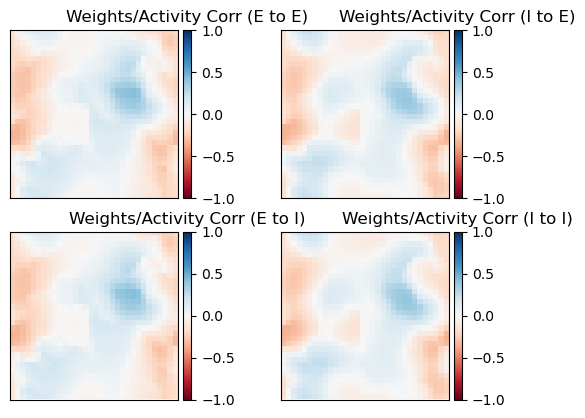

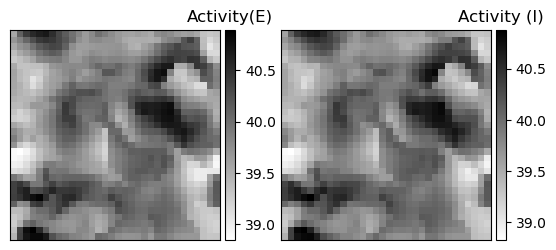

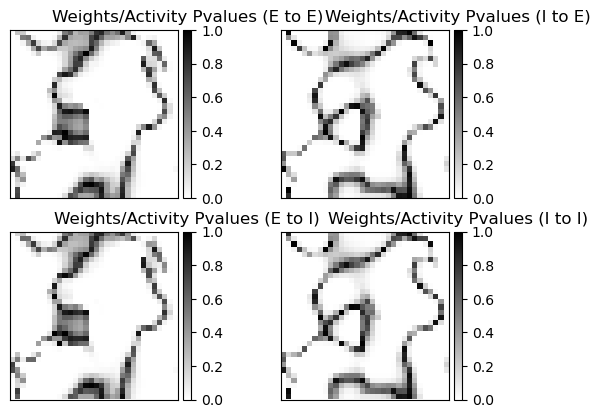

In [43]:
N4s = int(np.sqrt(N4))
print(N4s)
fig,axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.2, wspace=.2)
pf.imshowbar(fig,axs[0,0],correlations[0,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (E to E)')
pf.imshowbar(fig,axs[0,1],correlations[2,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (I to E)')
pf.imshowbar(fig,axs[1,0],correlations[1,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (E to I)')
pf.imshowbar(fig,axs[1,1],correlations[3,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (I to I)')

fig,axs = plt.subplots(1,2)
fig.subplots_adjust(hspace=.2, wspace=.2)
pf.imshowbar(fig,axs[0],l4[:N4].reshape(N4s,N4s),cmap='binary')
plt.title('Activity(E)')
pf.imshowbar(fig,axs[1],l4[N4:].reshape(N4s,N4s),cmap='binary')
plt.title('Activity (I)')

fig,axs = plt.subplots(2,2)
fig.subplots_adjust(hspace=.2, wspace=.2)
pf.imshowbar(fig,axs[0,0],pvalues[0,:].reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Weights/Activity Pvalues (E to E)')
pf.imshowbar(fig,axs[0,1],pvalues[2,:].reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Weights/Activity Pvalues (I to E)')
pf.imshowbar(fig,axs[1,0],pvalues[1,:].reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Weights/Activity Pvalues (E to I)')
pf.imshowbar(fig,axs[1,1],pvalues[3,:].reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Weights/Activity Pvalues (I to I)')

Text(0.5, 1.0, 'Weights/Activity Corr (E to E)')

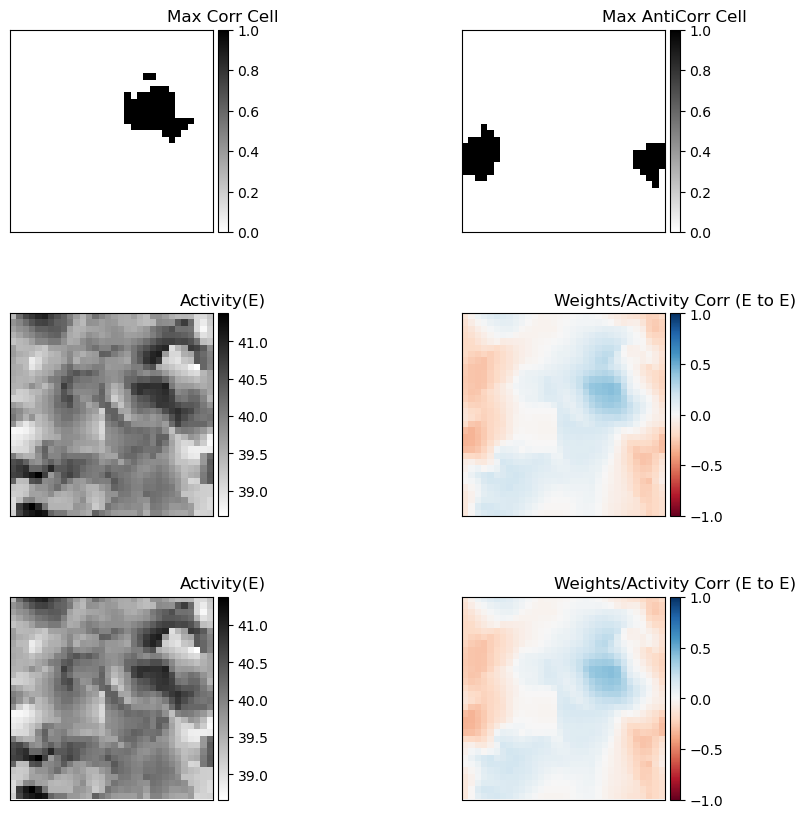

In [59]:
N4 = l4.shape[0]//2
N4s = int(np.sqrt(N4))
MaxCorrCellEE = np.argmax(correlations[0,:])
MaxAntiCorrCellEE = np.argmin(correlations[0,:])
WtoMax = W4_to_4[MaxCorrCellEE,:N4]
WtoMaxAnti = W4_to_4[MaxAntiCorrCellEE,:N4]
MaxWeigthttoMax = np.max(WtoMax)
MaxWeighttoMaxAnti = np.max(WtoMaxAnti)
r = 0.01
maskmax = WtoMax > MaxWeigthttoMax*r
maskanti = WtoMaxAnti > MaxWeighttoMaxAnti*r
WtoMax[maskmax] = 1
WtoMax[~maskmax] = 0
WtoMaxAnti[maskanti] = 1
WtoMaxAnti[~maskanti] = 0
fig,axs = plt.subplots(3,2,figsize=(10,10))
fig.subplots_adjust(hspace=.4, wspace=.4)
pf.imshowbar(fig,axs[0,0],WtoMax.reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Max Corr Cell')
pf.imshowbar(fig,axs[0,1],WtoMaxAnti.reshape(N4s,N4s),cmap='binary',vmin=0,vmax=1)
plt.title('Max AntiCorr Cell')
pf.imshowbar(fig,axs[1,0],l4[:N4].reshape(N4s,N4s),cmap='binary')
plt.title('Activity(E)')
pf.imshowbar(fig,axs[1,1],correlations[0,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (E to E)')
pf.imshowbar(fig,axs[2,0],l4[:N4].reshape(N4s,N4s),cmap='binary')
plt.title('Activity(E)')
pf.imshowbar(fig,axs[2,1],correlations[0,:].reshape(N4s,N4s),cmap='RdBu',vmin=-1,vmax=1)
plt.title('Weights/Activity Corr (E to E)')